In [2]:
%load_ext lab_black

In [3]:
def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100, min_value=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    array = array[(array >= min_value)]
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    return threshold


# def calc_kde(xy):
#     return gaussian_kde(xy)(xy)


def plot_frag_qc(
    x,
    y,
    ax,
    x_thr_min=None,
    x_thr_max=None,
    y_thr_min=None,
    y_thr_max=None,
    ylab=None,
    xlab="Number of (unique) fragments",
    cmap="viridis",
    density_overlay=False,
    s=10,
    marker="+",
    c="#343434",
    xlim=None,
    ylim=None,
    **kwargs
):
    from scipy.stats import gaussian_kde

    assert all(x.index == y.index)
    barcodes = x.index.values

    if density_overlay:
        cores = 8

        x_log = np.log(x)

        # Split input array for KDE [log(x), y] array in
        # equaly spaced parts (start_offset + n * nbr_cores).
        kde_parts = [np.vstack([x_log[i::cores], y[i::cores]]) for i in range(cores)]

        # Get nultiprocess context object to spawn processes.
        # mp_ctx = mp.get_context("spawn")

        # Calculate KDE in parallel.
        with Pool(processes=cores) as pool:
            results = pool.map(kde.calc_kde, kde_parts)

        z = np.concatenate(results)

        # now order x and y in the same way that z was ordered, otherwise random z value is assigned to barcode:
        x_ordered = np.concatenate([x[i::cores] for i in range(cores)])
        y_ordered = np.concatenate([y[i::cores] for i in range(cores)])

        idx = (
            z.argsort()
        )  # order based on z value so that highest value is plotted on top, and not hidden by lower values
        x, y, z, barcodes = x_ordered[idx], y_ordered[idx], z[idx], barcodes[idx]
    else:
        z = c

    sp = ax.scatter(x, y, c=z, s=s, edgecolors=None, marker=marker, cmap=cmap, **kwargs)
    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])
    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

    # Start with keeping all barcodes.
    barcodes_to_keep = np.full(x.shape[0], True)

    # Filter barcodes out if needed based on thresholds:
    if x_thr_min is not None:
        ax.axvline(x=x_thr_min, color="r", linestyle="--")

    if x_thr_max is not None:
        ax.axvline(x=x_thr_max, color="r", linestyle="--")

    if y_thr_min is not None:
        ax.axhline(y=y_thr_min, color="r", linestyle="--")

    if y_thr_max is not None:
        ax.axhline(y=y_thr_max, color="r", linestyle="--")

    ax.set_xscale("log")
    ax.set_xmargin(0.01)
    ax.set_ymargin(0.01)
    ax.set_xlabel(xlab, fontsize=10)
    ax.set_ylabel(ylab, fontsize=10)

In [ ]:
import jenkspy as jn

ModuleNotFoundError: No module named 'jenkspy'

In [5]:
import glob
import os
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [6]:
fragments_list = sorted(glob.glob("../1_data_repository/full_fragments/*.tsv.gz"))
fragments_dict = {}
for fragments_file in fragments_list:
    sample = fragments_file.split("/")[-1].split(".")[0]
    fragments_dict[sample] = fragments_file

In [7]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = metadata_bc_pkl_path.split("/")[-1].split(".")[0].split("__")[0]
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

In [8]:
metadata_bc_pkl_path_dict

{'BIO_ddseq_1': 'cistopic_qc_out/BIO_ddseq_1.FULL__metadata_bc.pkl',
 'BIO_ddseq_2': 'cistopic_qc_out/BIO_ddseq_2.FULL__metadata_bc.pkl',
 'BIO_ddseq_3': 'cistopic_qc_out/BIO_ddseq_3.FULL__metadata_bc.pkl',
 'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4.FULL__metadata_bc.pkl',
 'BRO_mtscatac_1': 'cistopic_qc_out/BRO_mtscatac_1.FULL__metadata_bc.pkl',
 'BRO_mtscatac_2': 'cistopic_qc_out/BRO_mtscatac_2.FULL__metadata_bc.pkl',
 'CNA_10xmultiome_1': 'cistopic_qc_out/CNA_10xmultiome_1.FULL__metadata_bc.pkl',
 'CNA_10xmultiome_2': 'cistopic_qc_out/CNA_10xmultiome_2.FULL__metadata_bc.pkl',
 'CNA_10xv11_1': 'cistopic_qc_out/CNA_10xv11_1.FULL__metadata_bc.pkl',
 'CNA_10xv11_2': 'cistopic_qc_out/CNA_10xv11_2.FULL__metadata_bc.pkl',
 'CNA_10xv11_3': 'cistopic_qc_out/CNA_10xv11_3.FULL__metadata_bc.pkl',
 'CNA_10xv11_4': 'cistopic_qc_out/CNA_10xv11_4.FULL__metadata_bc.pkl',
 'CNA_10xv11_5': 'cistopic_qc_out/CNA_10xv11_5.FULL__metadata_bc.pkl',
 'CNA_10xv2_1': 'cistopic_qc_out/CNA_10xv2_1.FULL__metada

# First let's try Otsu's algorithm

	plotting 5429 values...
	BIO_ddseq_1: 6077 cells detected with threshold 1021.9149259448299


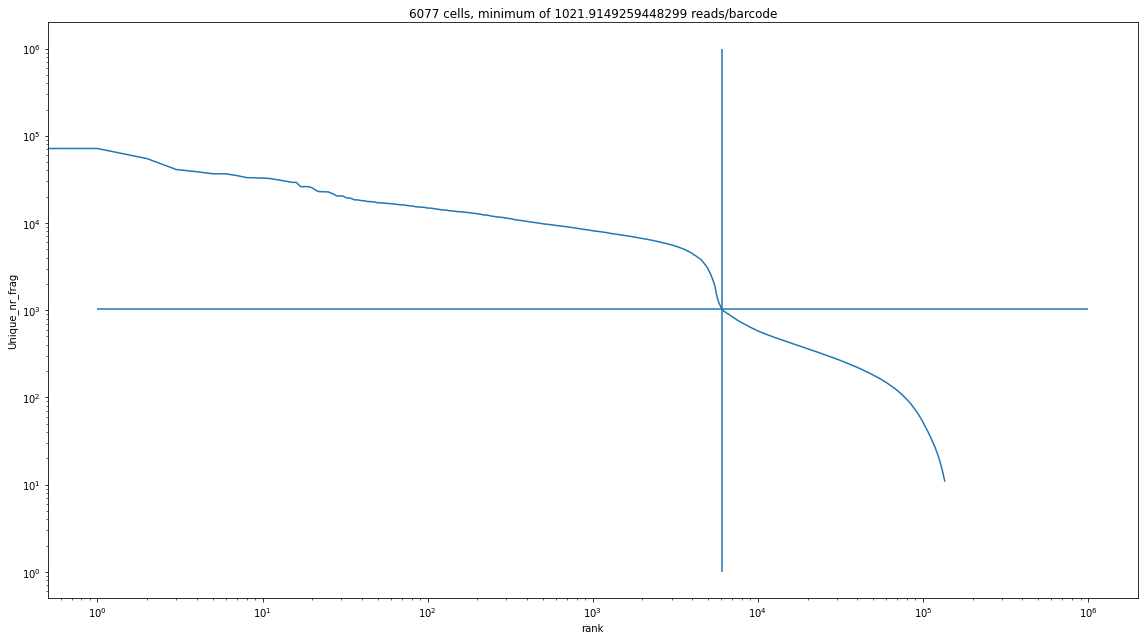

	plotting 5814 values...
	BIO_ddseq_2: 5631 cells detected with threshold 1232.7560374023649


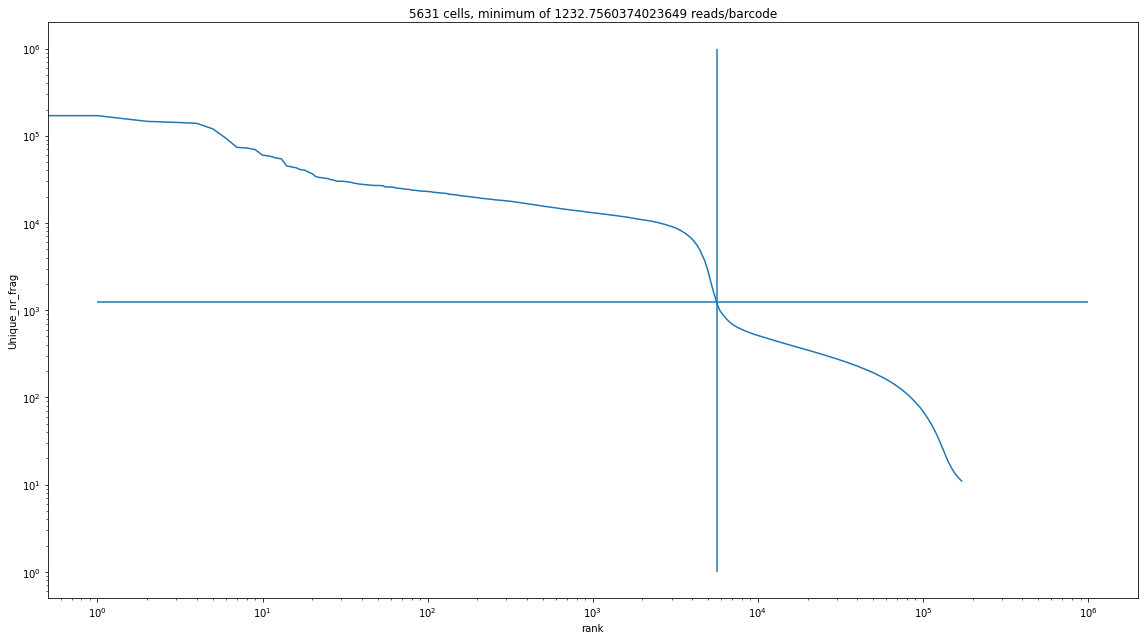

	plotting 3502 values...
	BIO_ddseq_3: 3142 cells detected with threshold 925.7458637571051


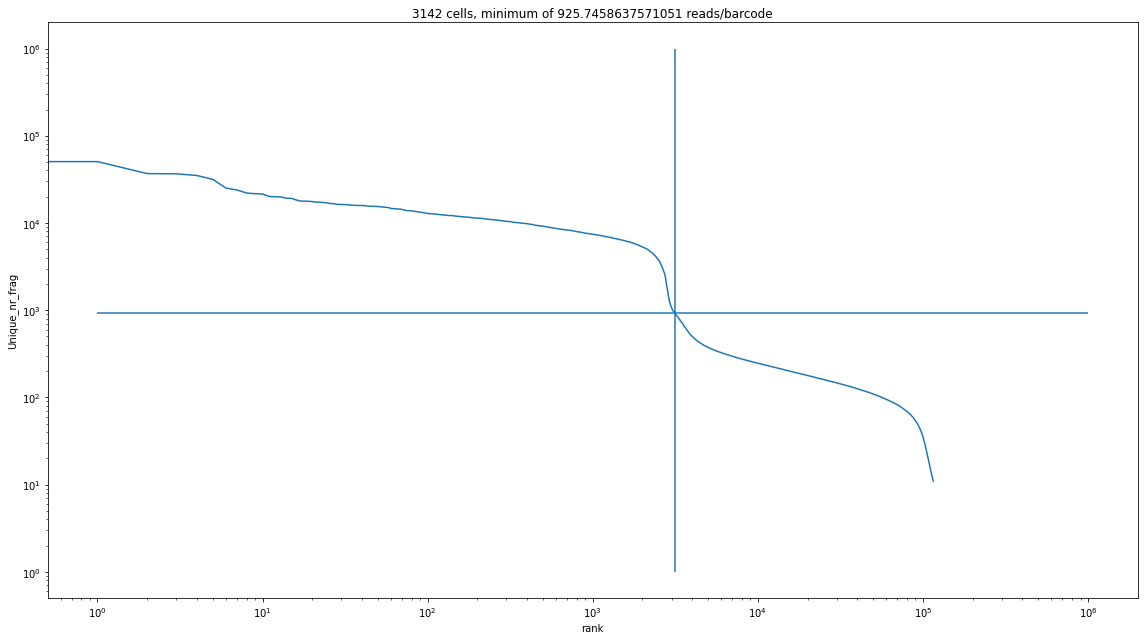

	plotting 3453 values...
	BIO_ddseq_4: 2989 cells detected with threshold 976.3518639154777


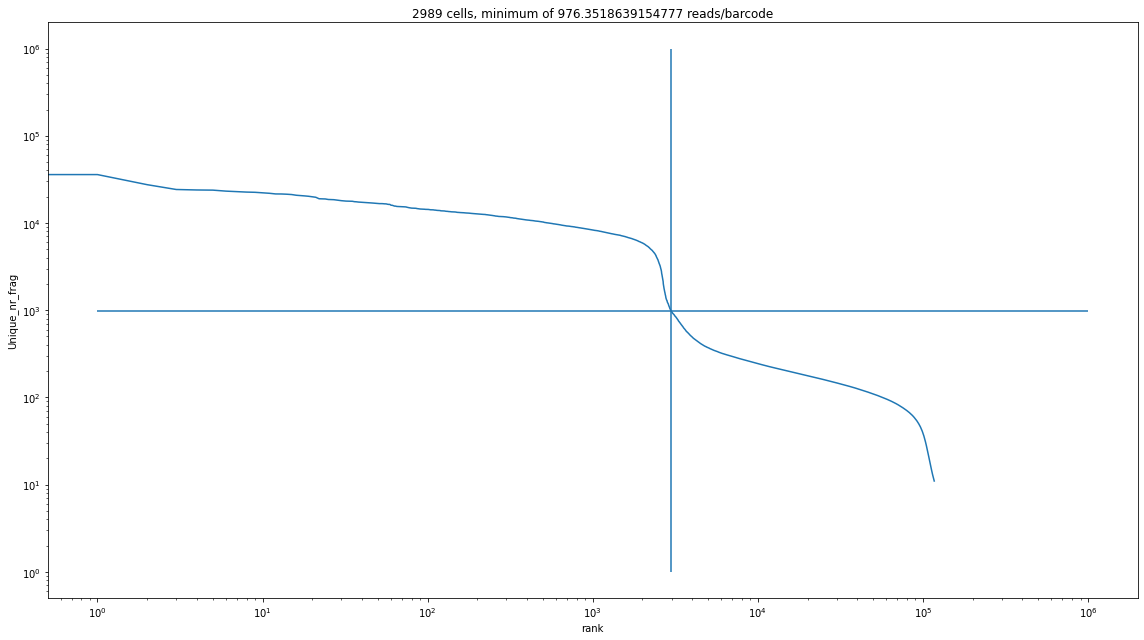

	plotting 3808 values...
	BRO_mtscatac_1: 3663 cells detected with threshold 1611.1158068763548


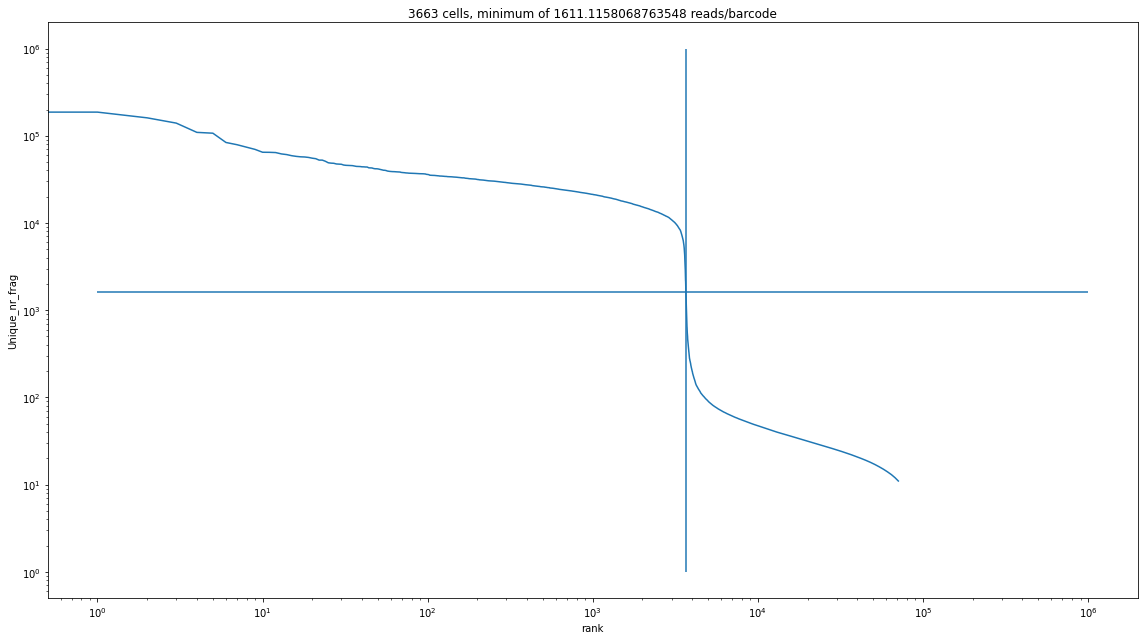

	plotting 3693 values...
	BRO_mtscatac_2: 3488 cells detected with threshold 1573.1422057218488


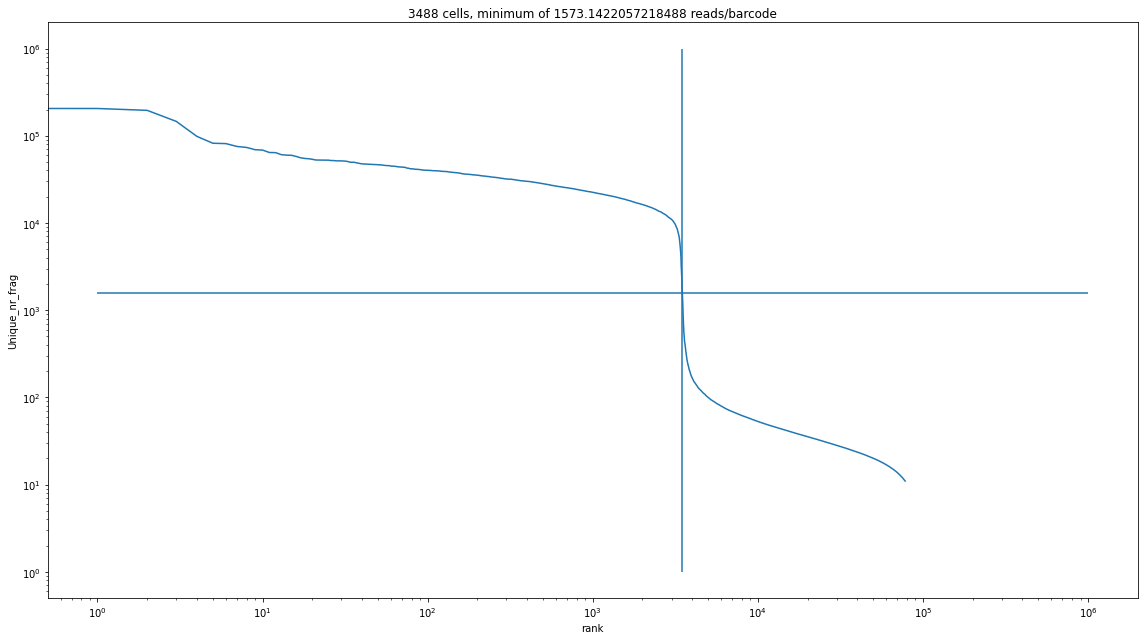

	plotting 4719 values...
	CNA_10xmultiome_1: 3811 cells detected with threshold 1386.5442897974888


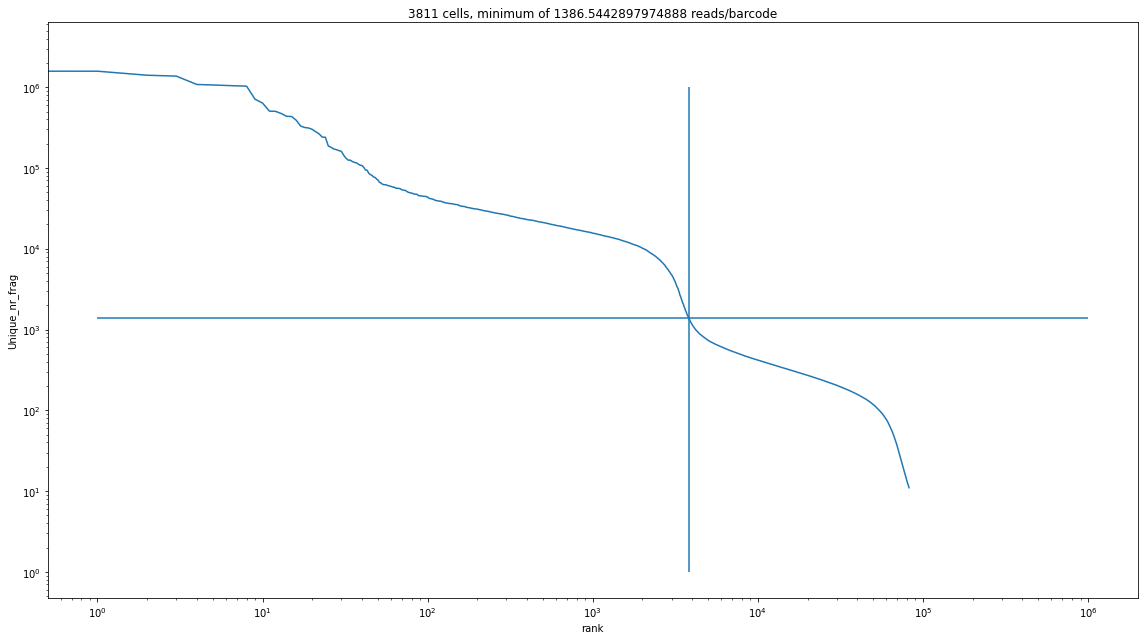

	plotting 4597 values...
	CNA_10xmultiome_2: 3751 cells detected with threshold 1312.140969766109


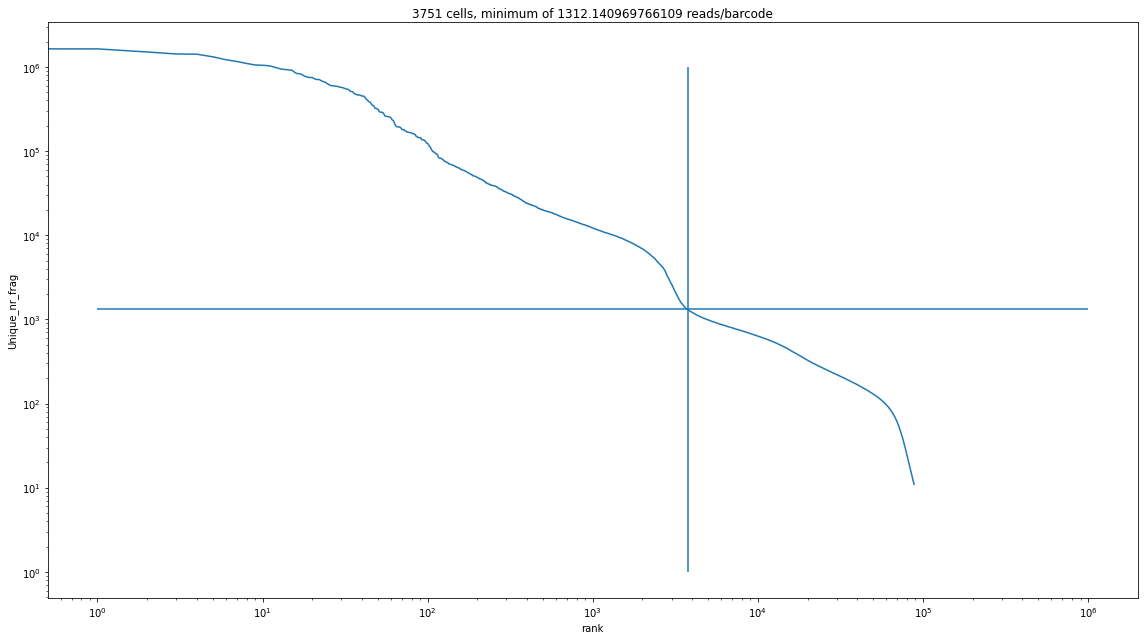

	plotting 5235 values...
	CNA_10xv11_2: 4135 cells detected with threshold 1733.7821785620927


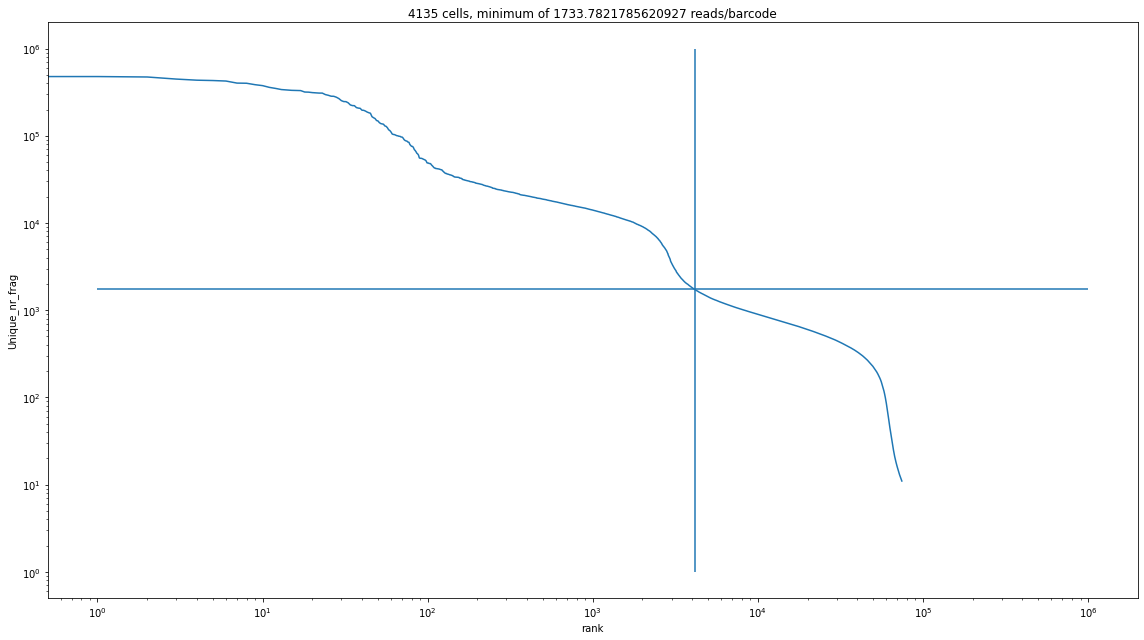

	plotting 6448 values...
	CNA_10xv11_3: 5431 cells detected with threshold 1706.802812851339


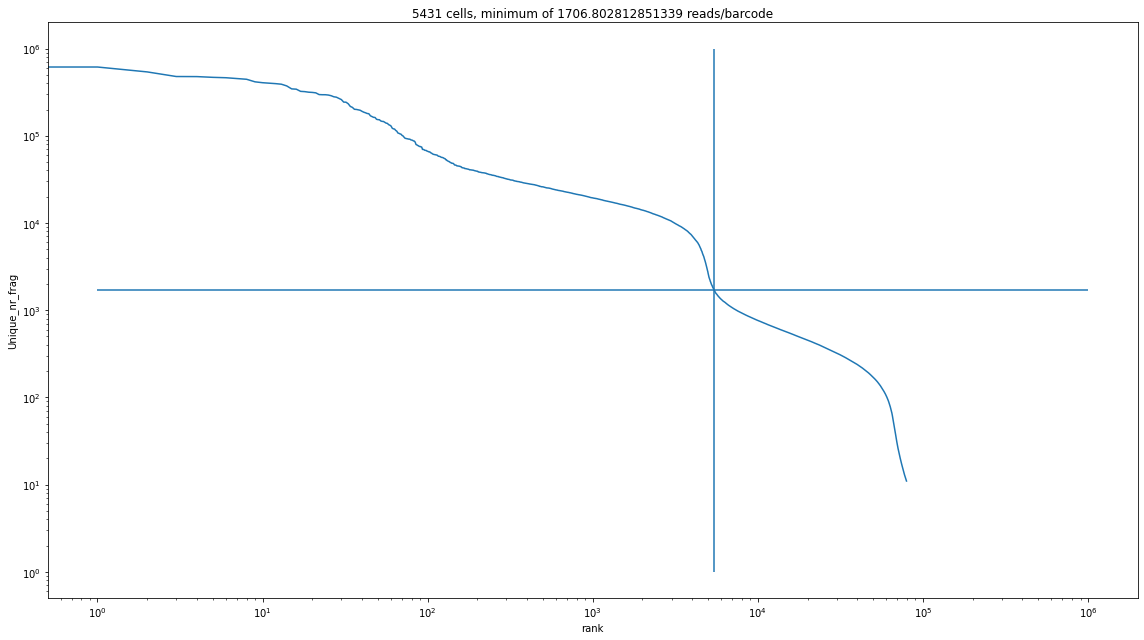

	plotting 1832 values...
	CNA_10xv11_4: 836 cells detected with threshold 2370.7527772984763


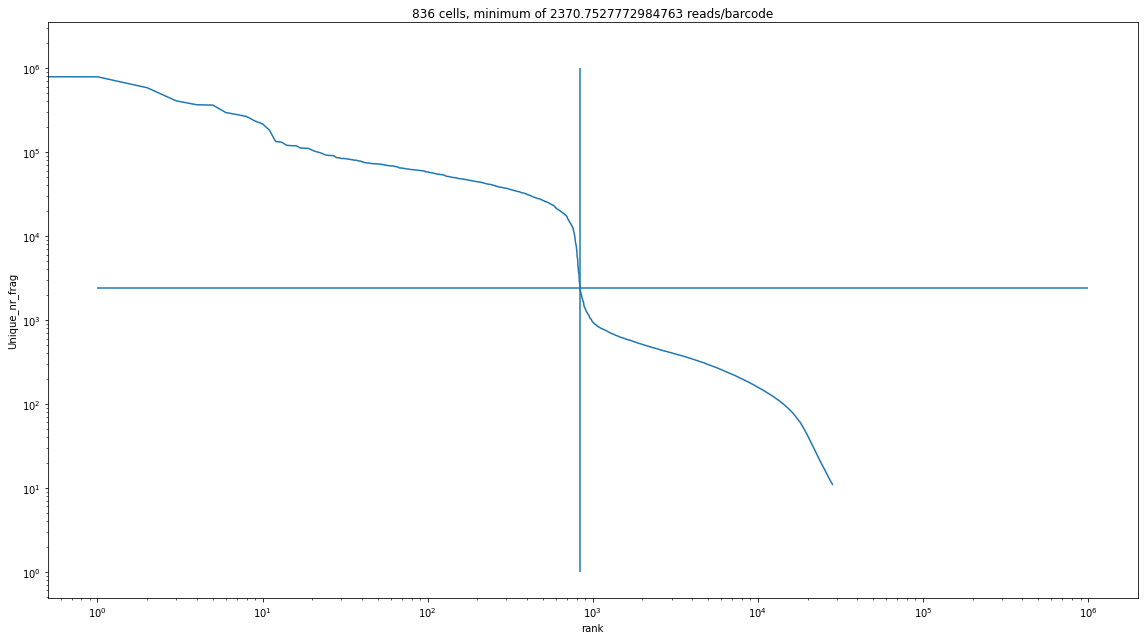

	plotting 1865 values...
	CNA_10xv11_5: 1179 cells detected with threshold 1880.3779409176984


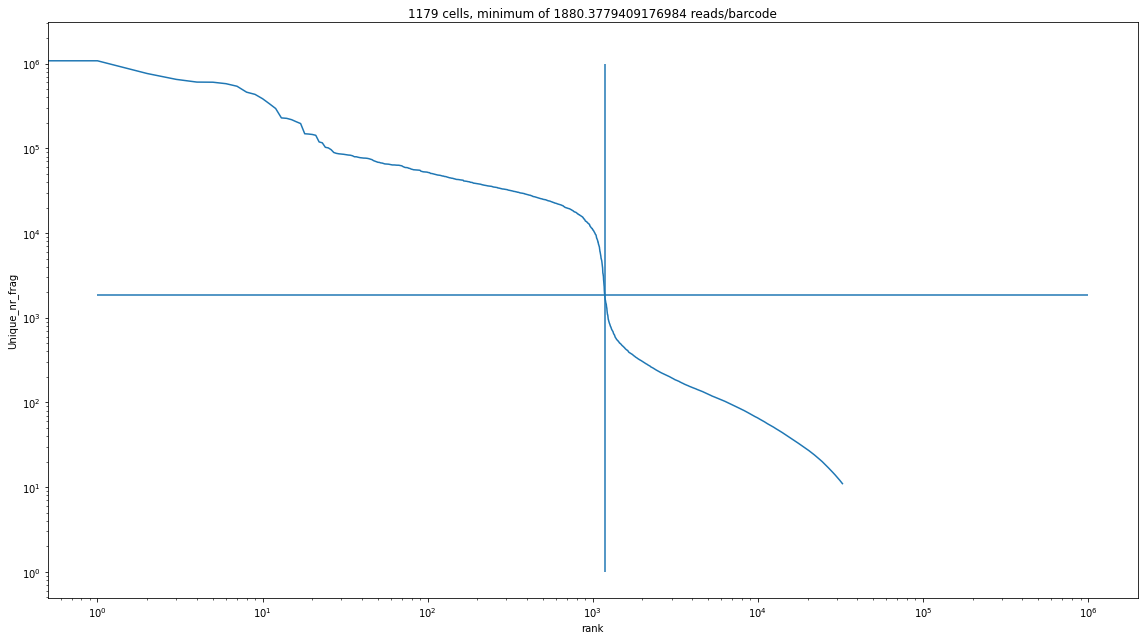

	plotting 4525 values...
	CNA_10xv2_1: 4319 cells detected with threshold 1534.9903499663926


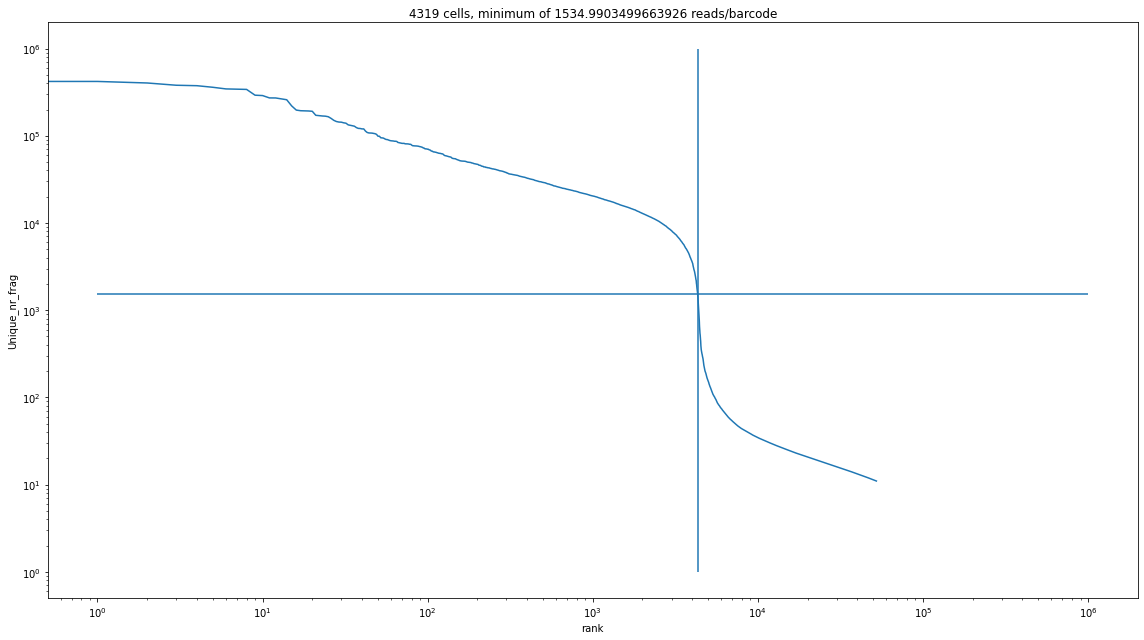

	plotting 1319 values...
	CNA_ddseq_1: 767 cells detected with threshold 1805.0482035629643


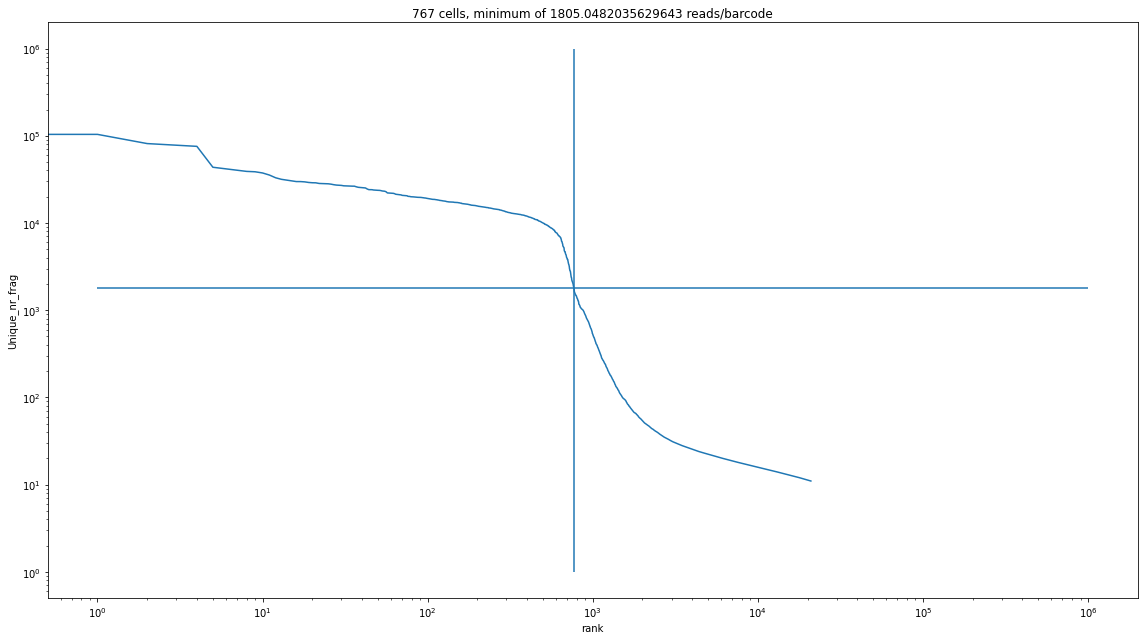

	plotting 1281 values...
	CNA_ddseq_2: 754 cells detected with threshold 1796.5862486108713


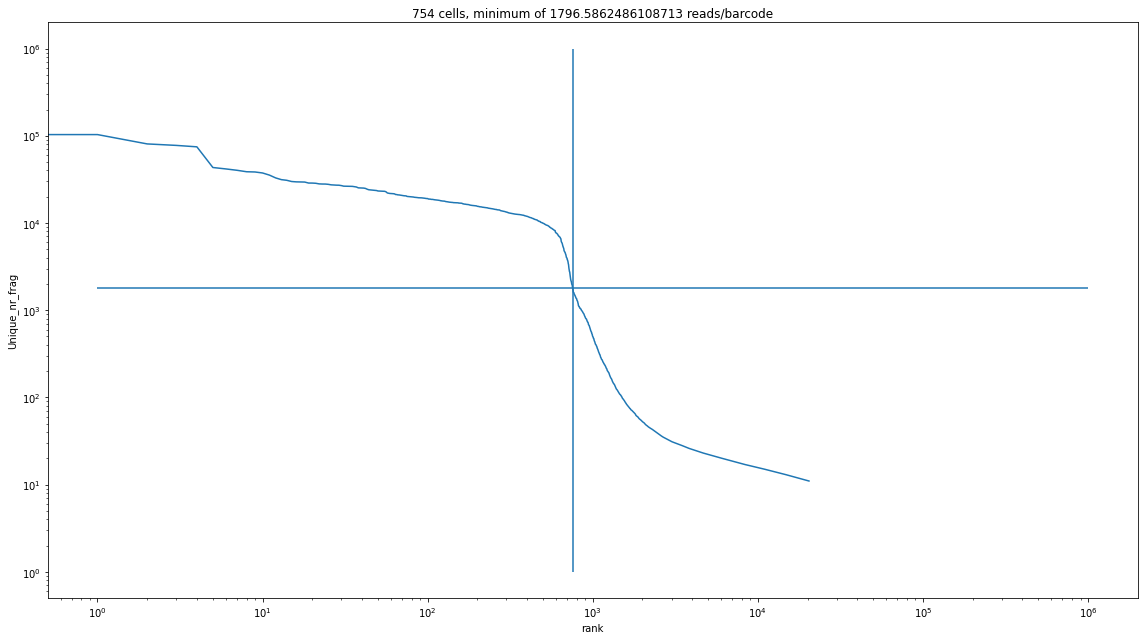

	plotting 2071 values...
	CNA_mtscatac_2: 1516 cells detected with threshold 1946.1887570620886


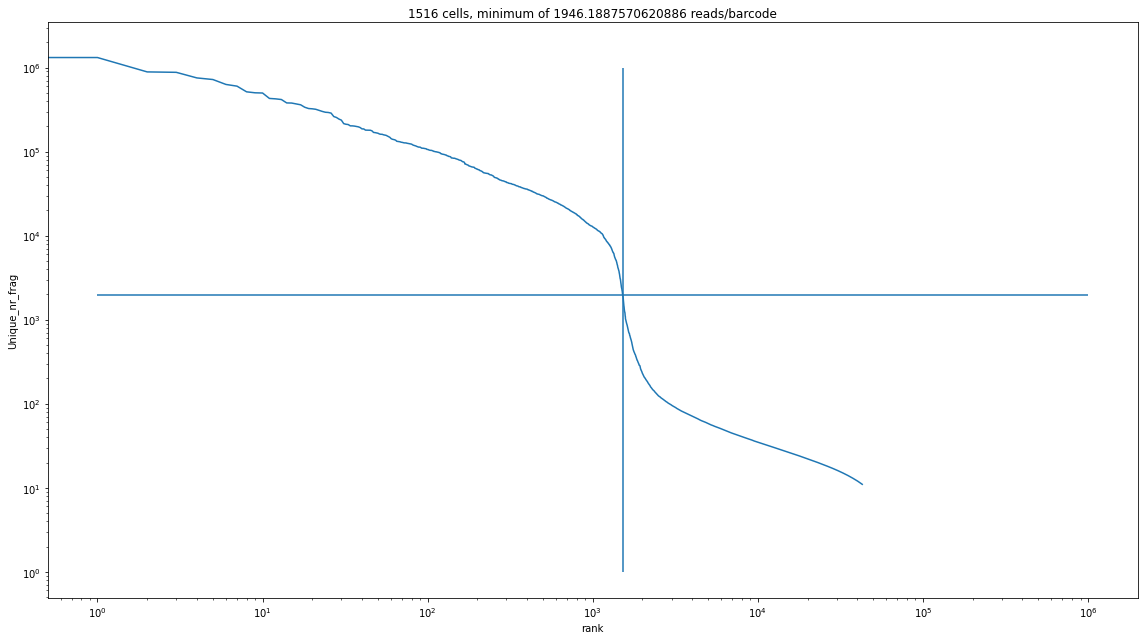

	plotting 5675 values...
	HAR_ddseq_1: 5155 cells detected with threshold 1361.1345651531324


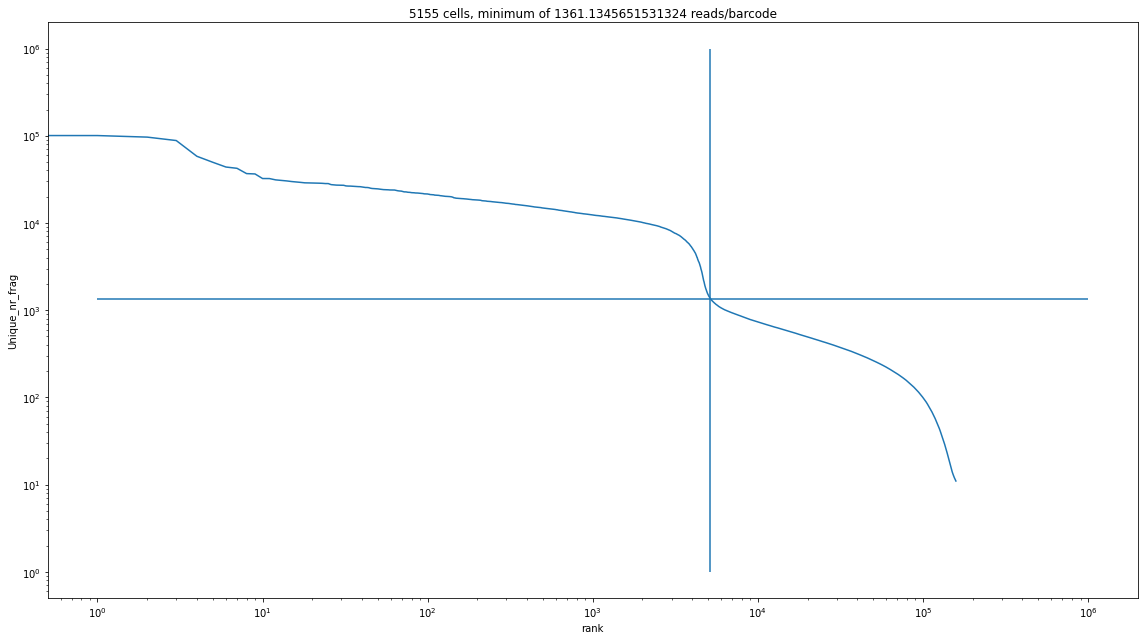

	plotting 6032 values...
	HAR_ddseq_2: 7014 cells detected with threshold 1119.862490123795


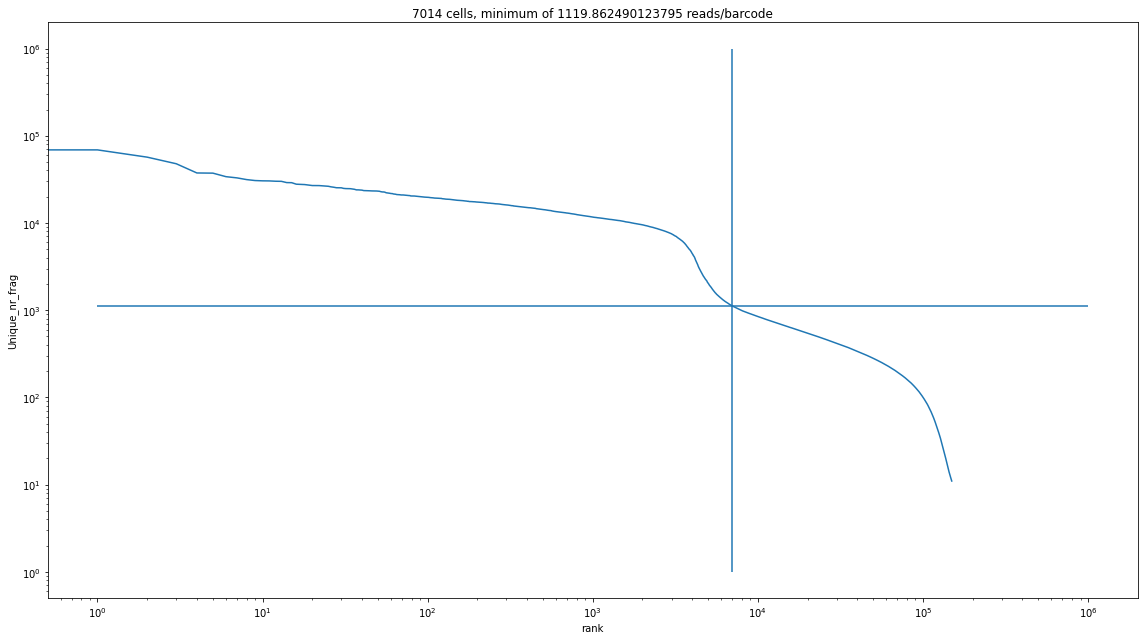

	plotting 8708 values...
	MDC_mtscatac_1: 8817 cells detected with threshold 1672.6058446061757


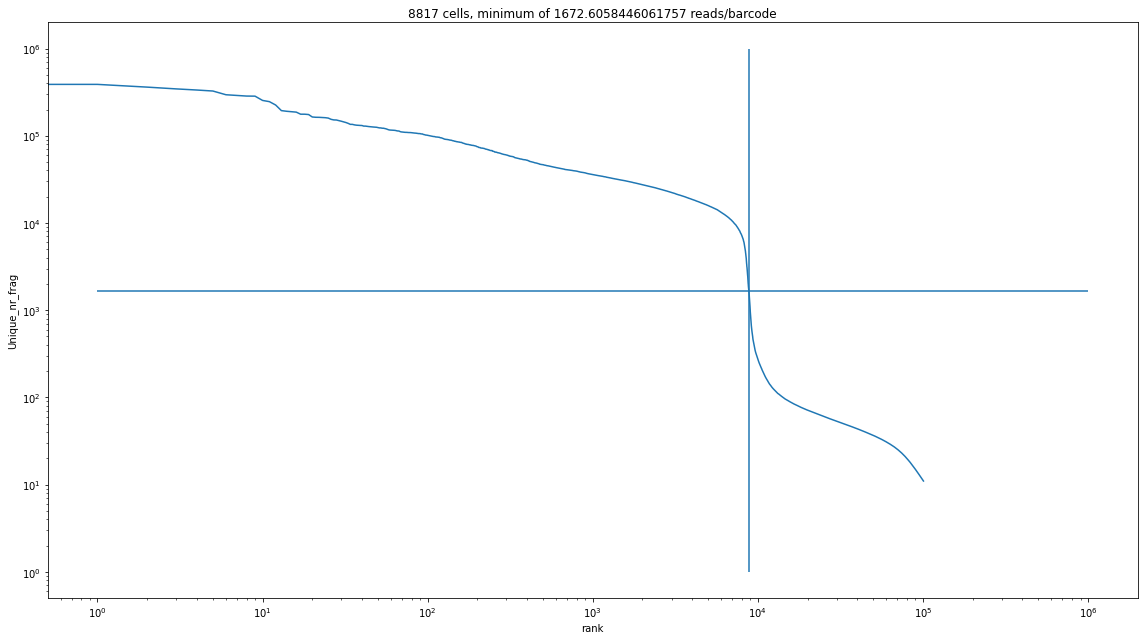

	plotting 6899 values...
	MDC_mtscatac_2: 6564 cells detected with threshold 1686.220099308635


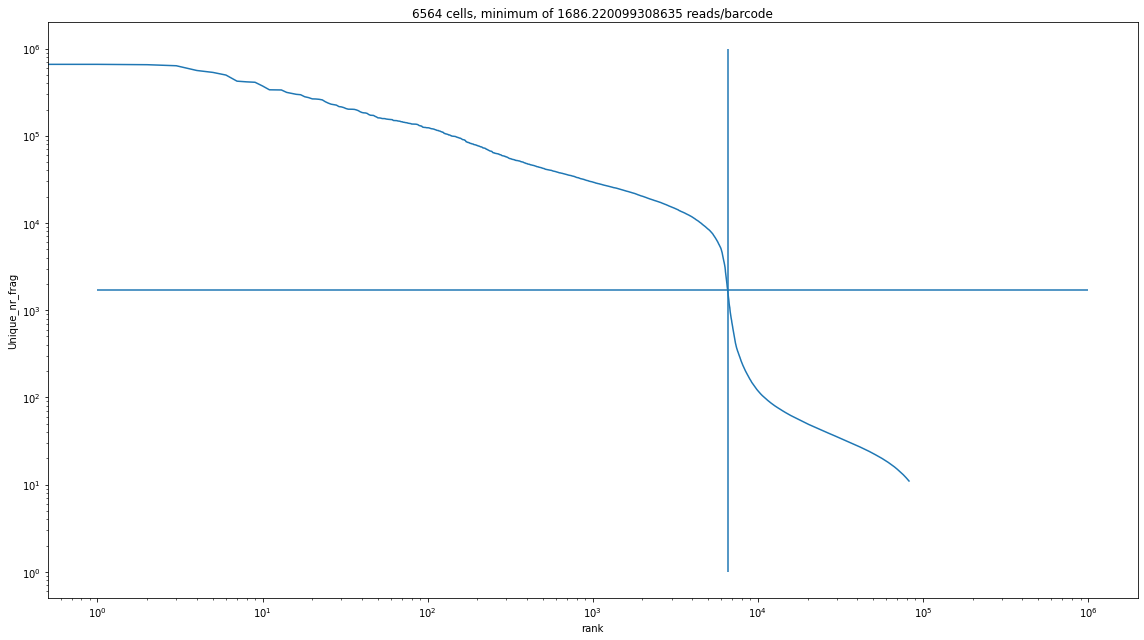

	plotting 5455 values...
	SAN_10xmultiome_1: 3778 cells detected with threshold 2745.9967189908266


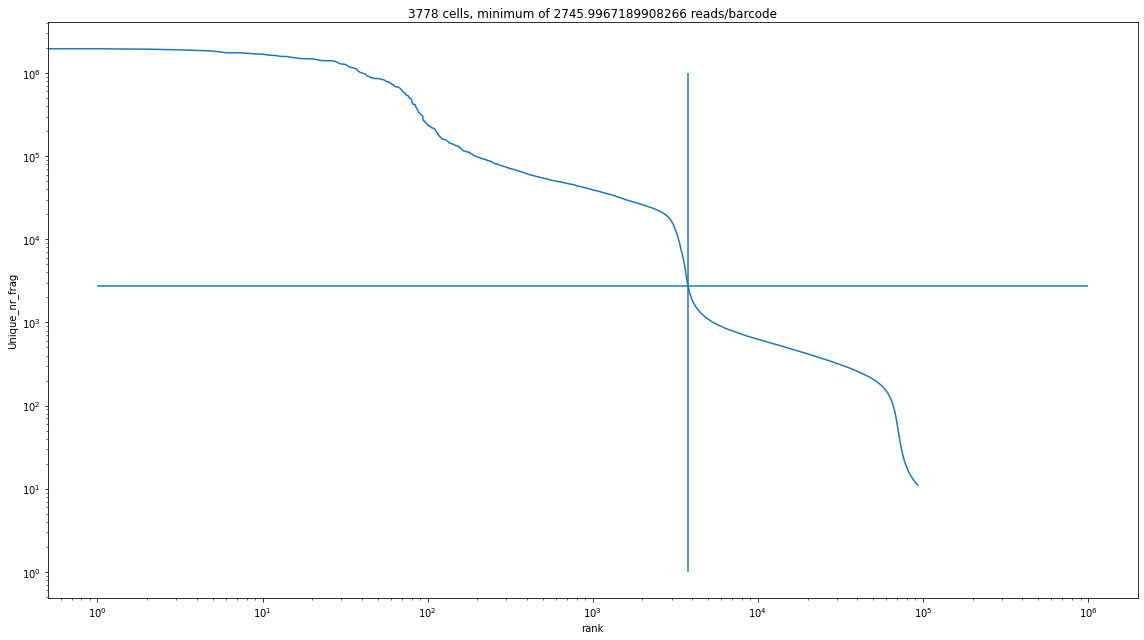

	plotting 6220 values...
	SAN_10xmultiome_2: 4605 cells detected with threshold 2506.4037893936925


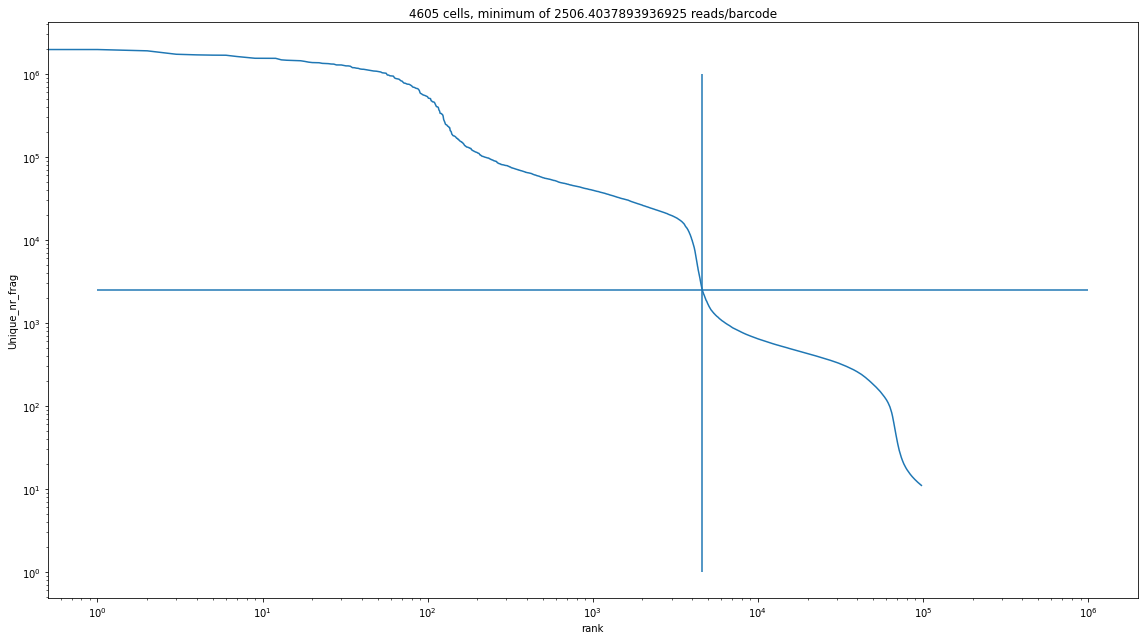

	plotting 5462 values...
	STA_10xv11_1: 20150 cells detected with threshold 849.4514429673728


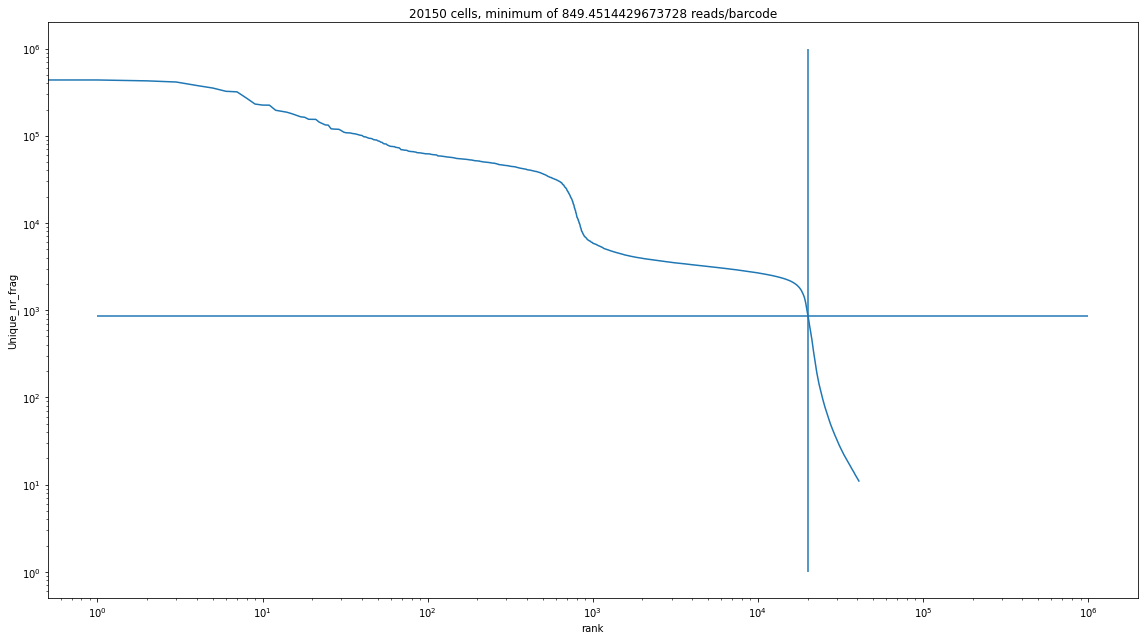

	plotting 4882 values...
	STA_10xv11_2: 30324 cells detected with threshold 670.078986785603


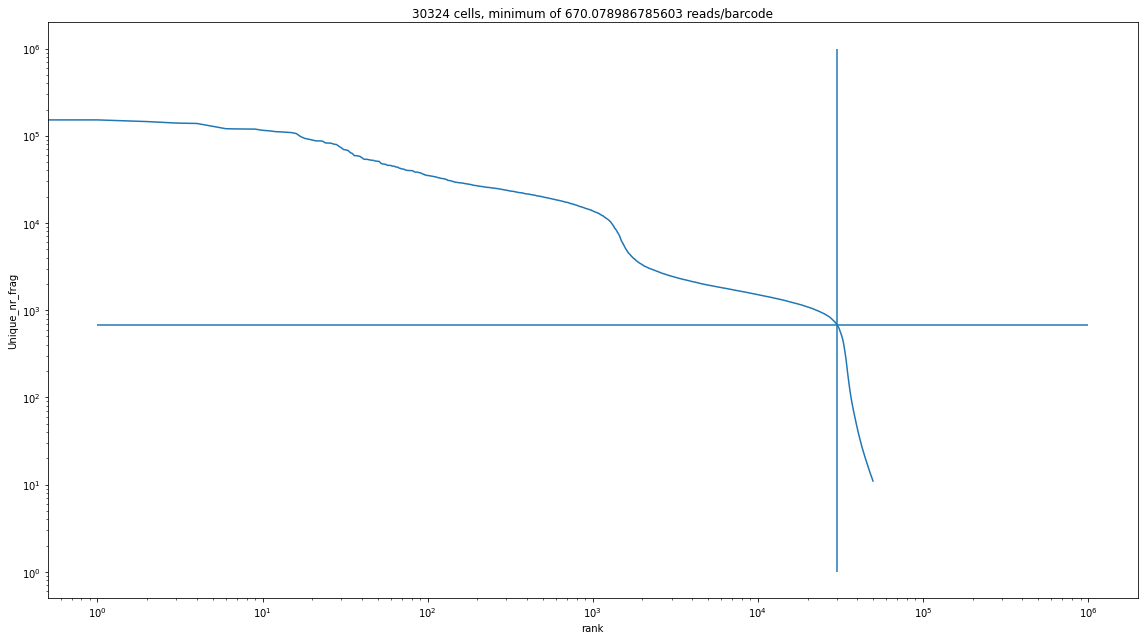

	plotting 12358 values...
	TXG_10xv11_1: 11587 cells detected with threshold 3122.6443490230695


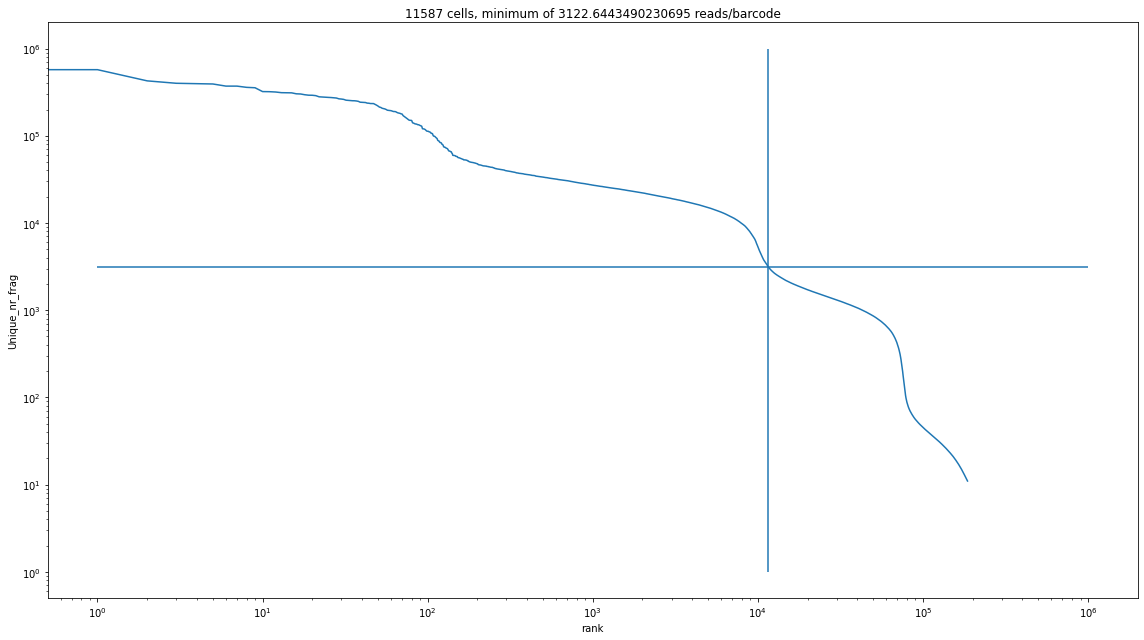

	plotting 9547 values...
	TXG_10xv2_1: 10273 cells detected with threshold 1731.6807140214657


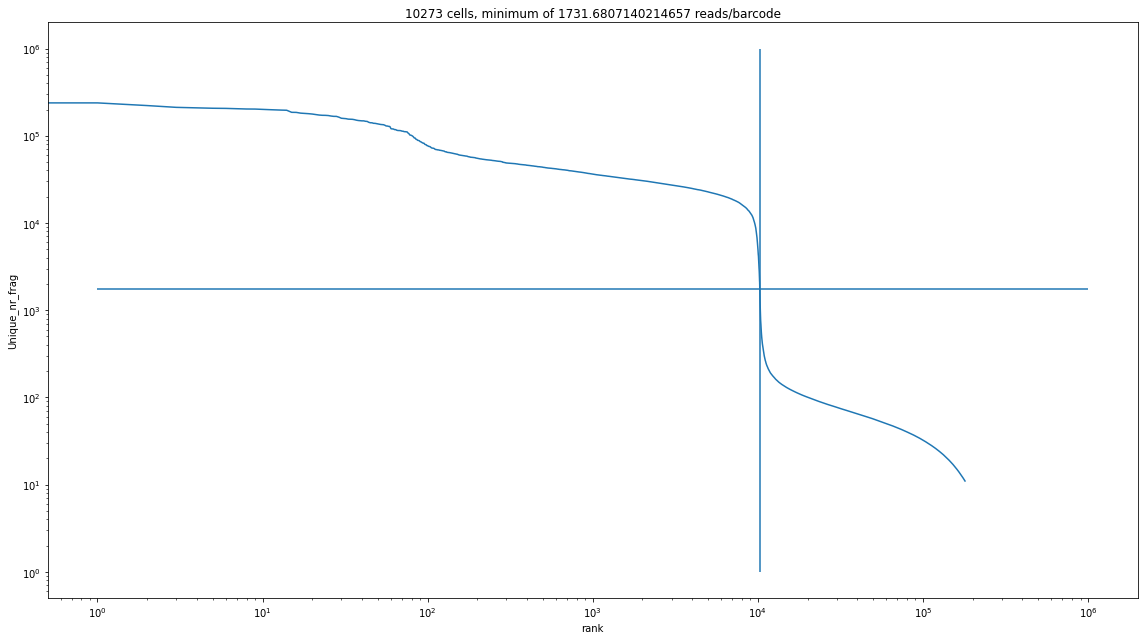

In [31]:
for sample in sorted(metadata_bc_pkl_path_dict.keys()):
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        
    df = pd.DataFrame(metadata_bc_df["Unique_nr_frag"])
    # calculate otsu threshold
    df = df.sort_values("Unique_nr_frag", ascending=False)
    df["rank"] = range(0, len(df))
    df["log"] = np.log10(df["Unique_nr_frag"])
    threshold = 10**threshold_otsu(df["log"], min_value=np.log10(100))

    ncells = len(df[df["Unique_nr_frag"] > threshold])
    df_fast_knee = df.drop_duplicates(subset=["Unique_nr_frag"])

    print(f"\tplotting {len(df_fast_knee)} values...")
    fig, ax = plt.subplots()
    sns.lineplot(data=df_fast_knee, x="rank", y="Unique_nr_frag", ax=ax)

    print(
        f"\t{sample}: {ncells} cells detected with threshold {threshold}"
    )
    plt.xscale("log")
    plt.yscale("log")

    plt.hlines(y=threshold, xmin=1, xmax=1000000)
    plt.vlines(x=ncells, ymin=1, ymax=1000000)
    fig.set_size_inches(16, 9)

    plt.title(f"{ncells} cells, minimum of {threshold} reads/barcode")
    plt.tight_layout()
    # plt.savefig(f"plts_bc_count/{run}.raw_kneeplot.png", facecolor="white", dpi=300)
    plt.show()
    plt.close()

In [15]:
sample="HAR_ddseq_1"
with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
    metadata_bc_df = pickle.load(fh)

df = pd.DataFrame(metadata_bc_df["Log_unique_nr_frag"])
# calculate otsu threshold
df = df.sort_values("Log_unique_nr_frag", ascending=False)


In [16]:
df

,Log_unique_nr_frag
CGTACAACGATTACCGCGGCG_TAAGAGGGGTAACATGGTGAA___HAR_ddseq_1,5.286670
CACGGACAGACTTCTCGACAG_CGTAGCCTGGTGAAACGTTGG___HAR_ddseq_1,5.002473
CATCAGTACTCAATGTCCTTC_TACTTTCGTGTGTCGCCTCGT___HAR_ddseq_1,4.984671
AGCGAATACCTACCCCATAAT_ATATAACACTACGAGGAAGTT___HAR_ddseq_1,4.945355
AAGGTTCGAGGACACTAAGAA_CTGCGCCGTTGATGAACGTAA_TGGCAACTTGGACTTGGCAAC___HAR_ddseq_1,4.764901
...,...
CTATTCGTAGTACCGCCTCGT___HAR_ddseq_1,1.041393
CTTCATCGCAGTGTCCAGTCA___HAR_ddseq_1,1.041393
TCTGAACTCCTTAATGCGTTG___HAR_ddseq_1,1.041393
TTTGGTCGATAGACCTCATTT___HAR_ddseq_1,1.041393


# How about Jenks?

In [18]:
jn.jenks_breaks(df["Log_unique_nr_frag"], nb_class=2)

[1.041392685158225, 2.0170333392987803, 5.286669747130304]

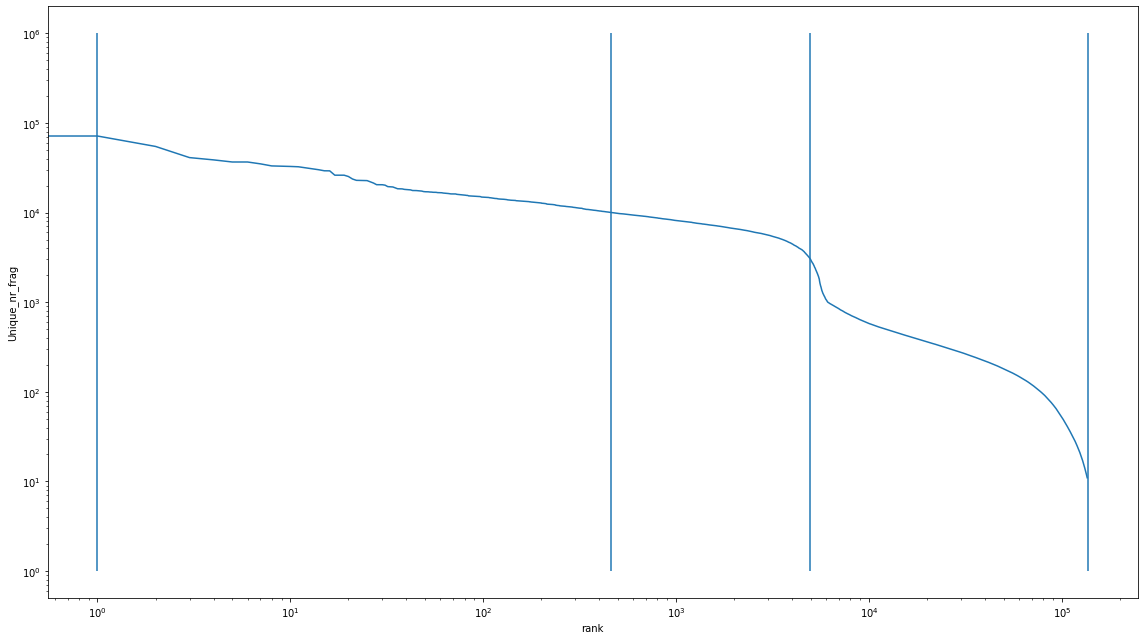

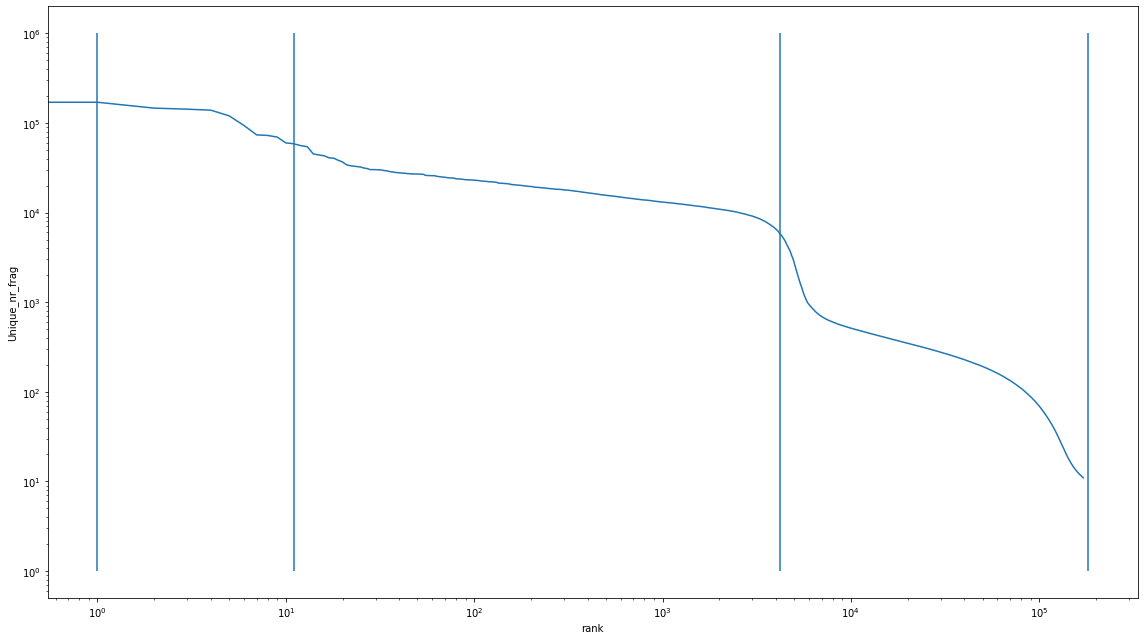

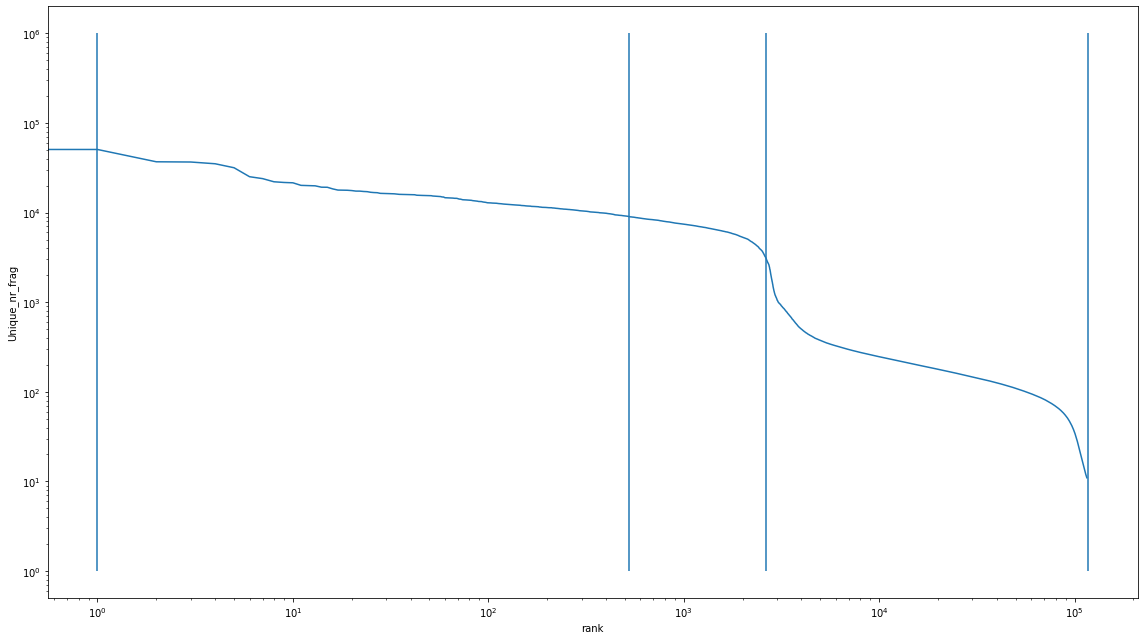

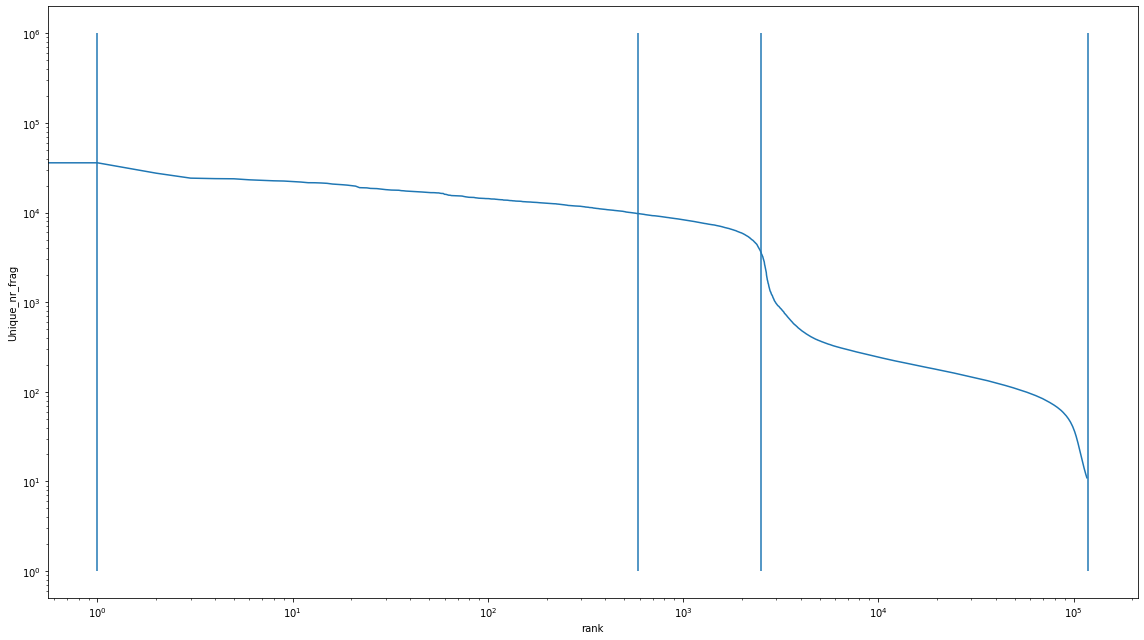

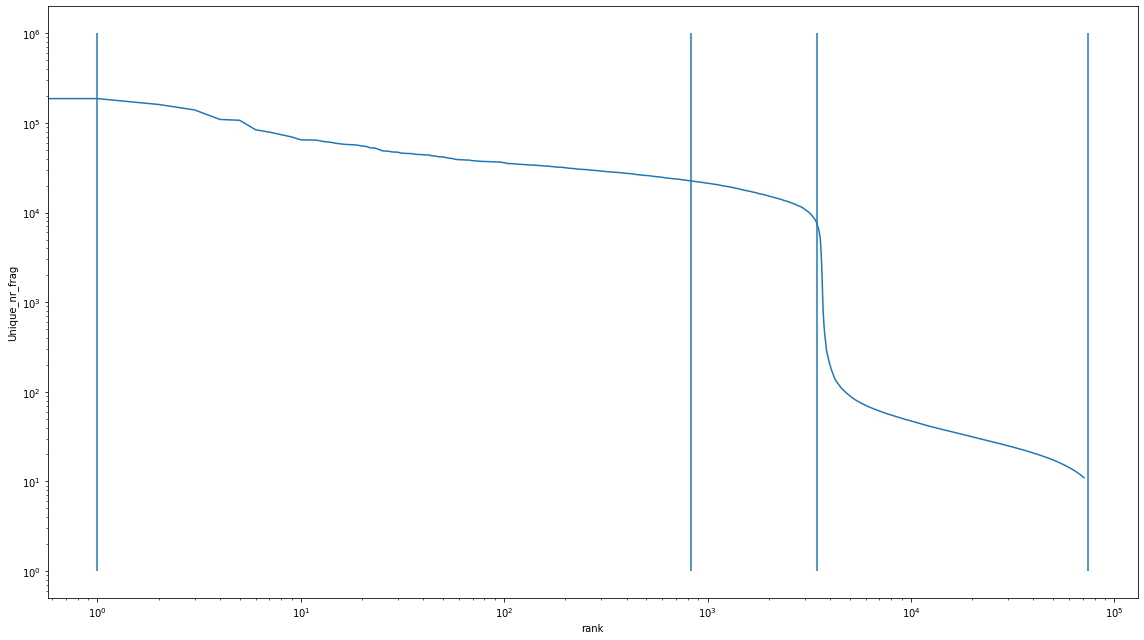

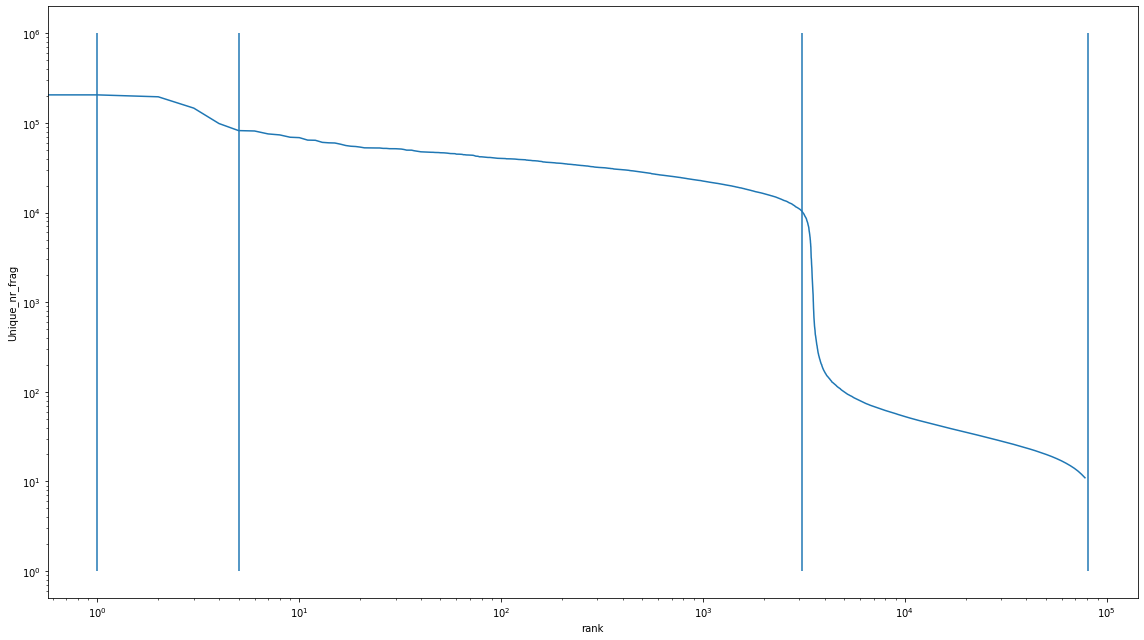

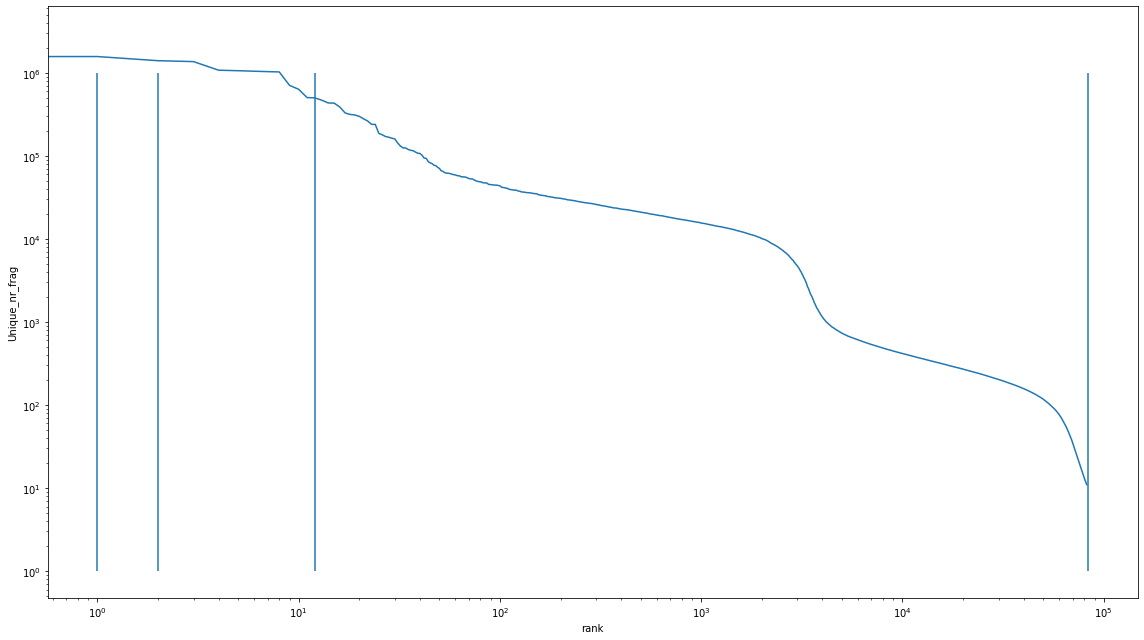

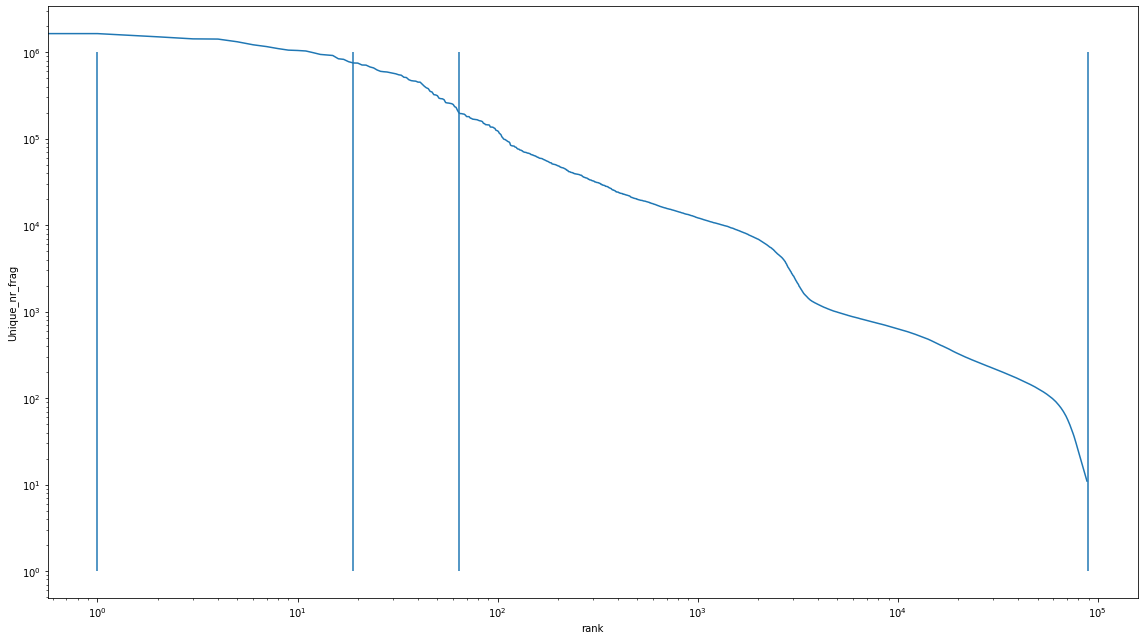

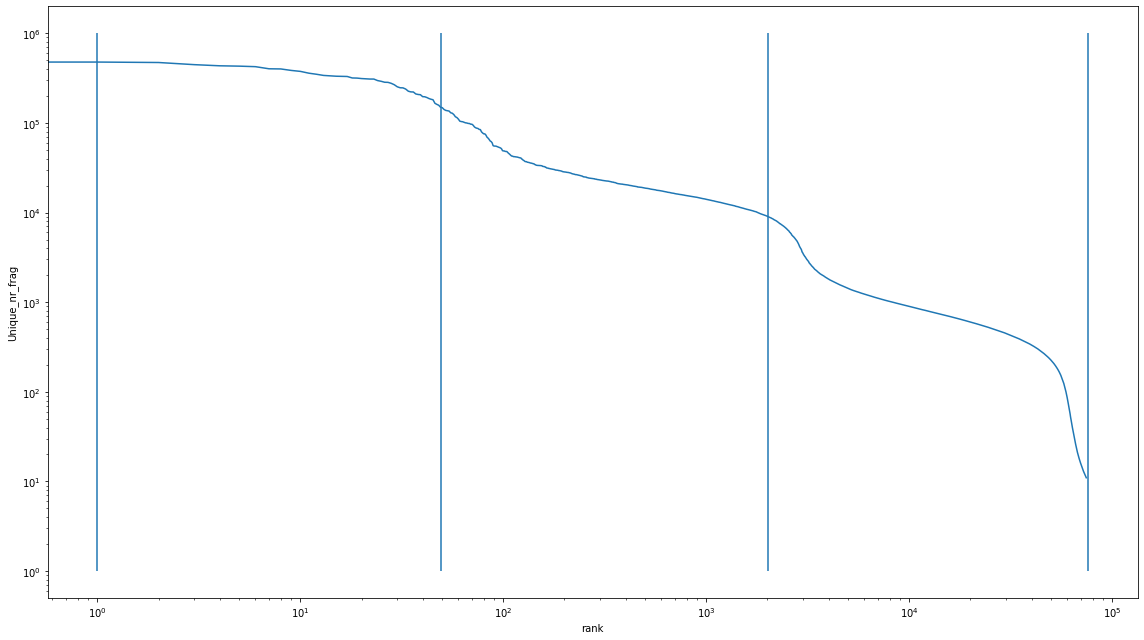

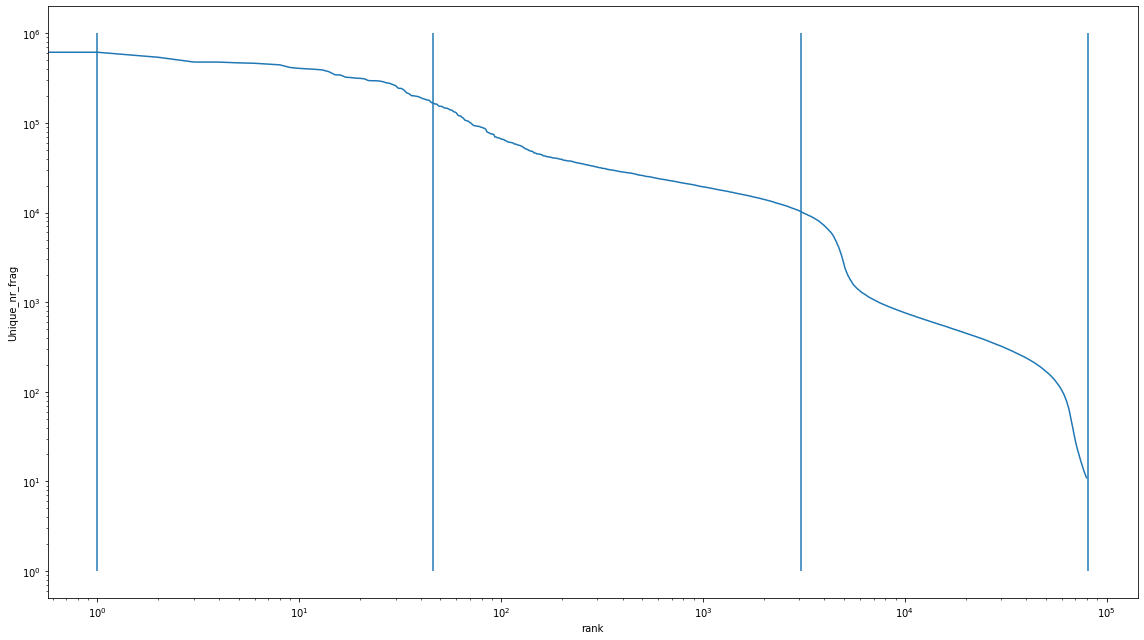

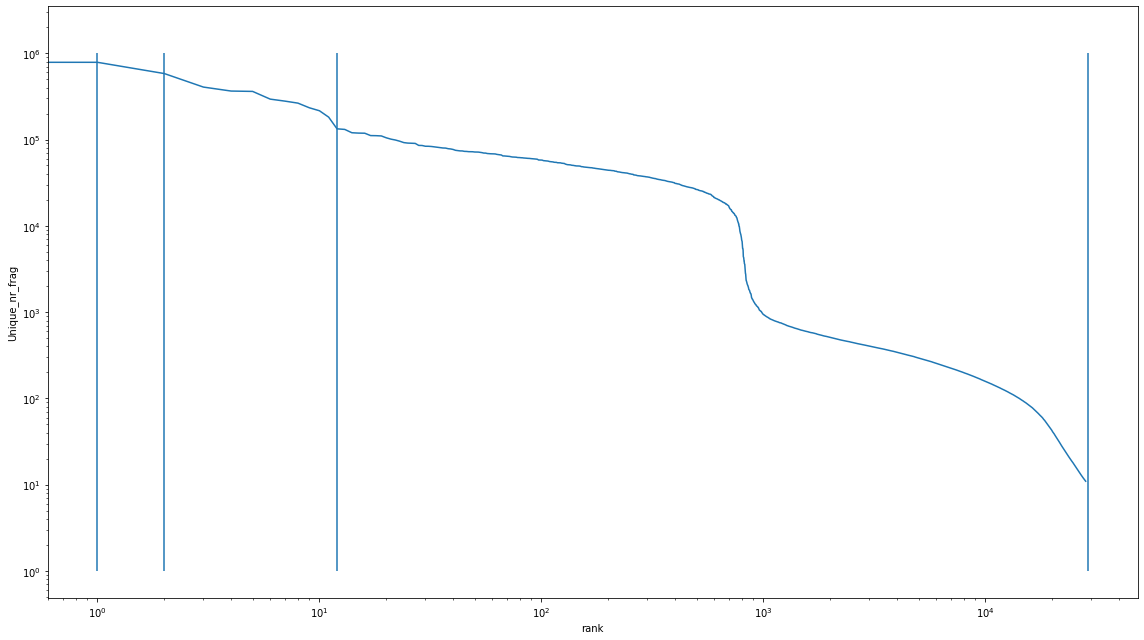

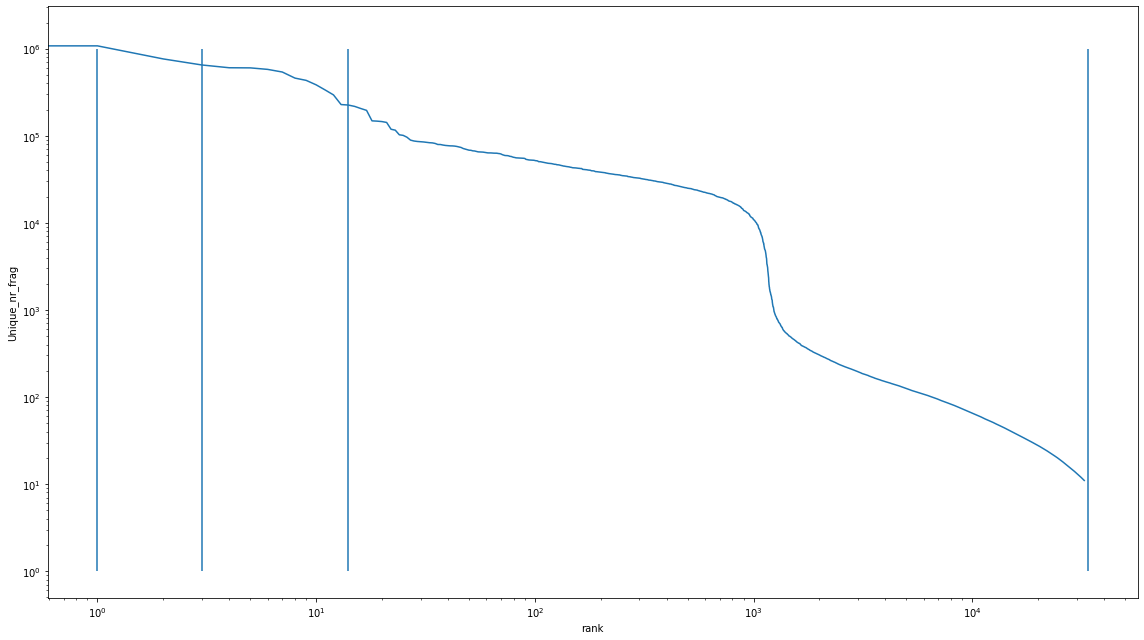

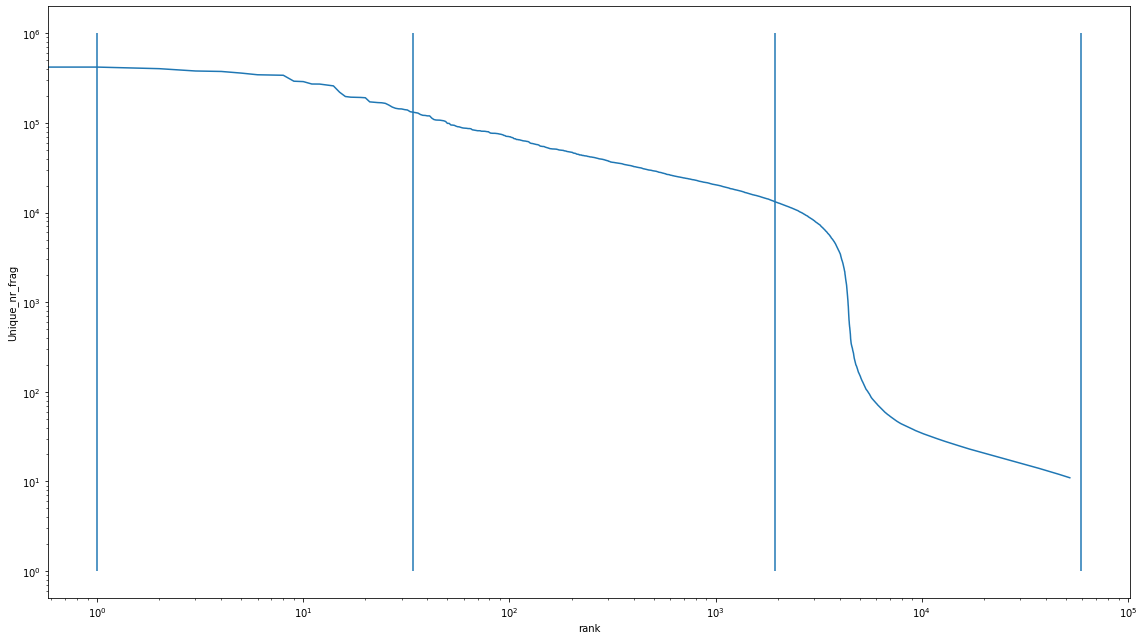

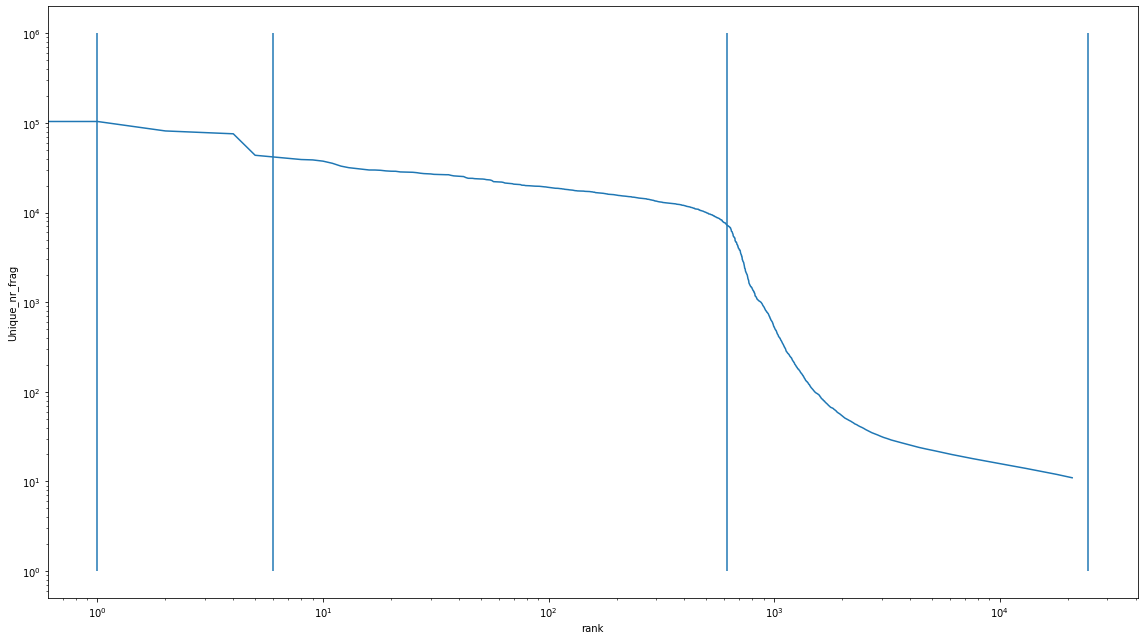

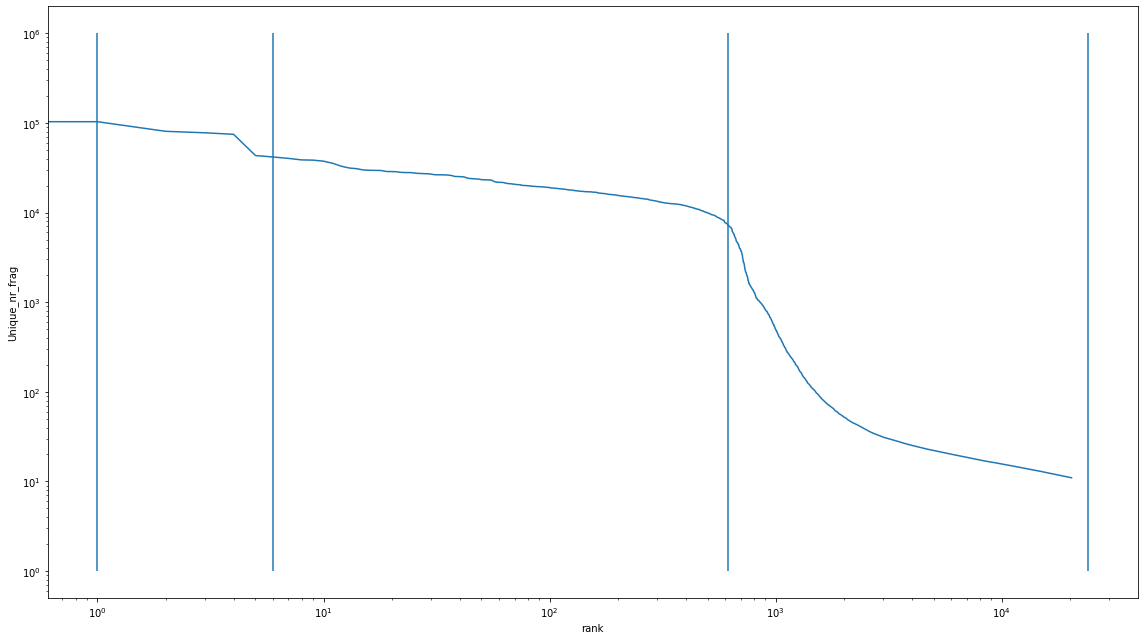

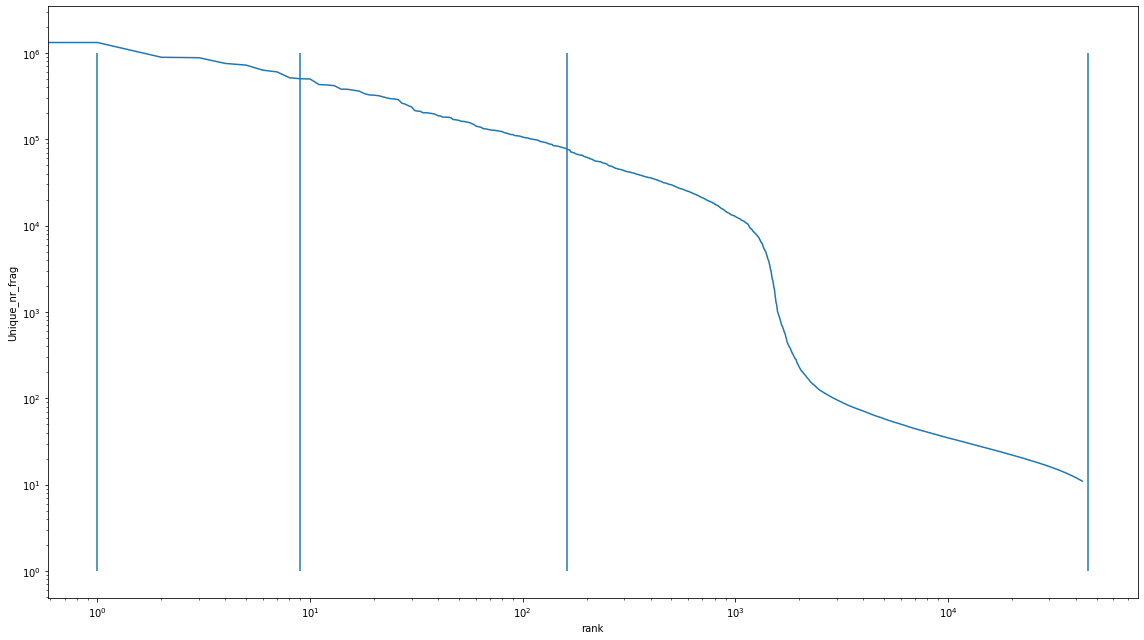

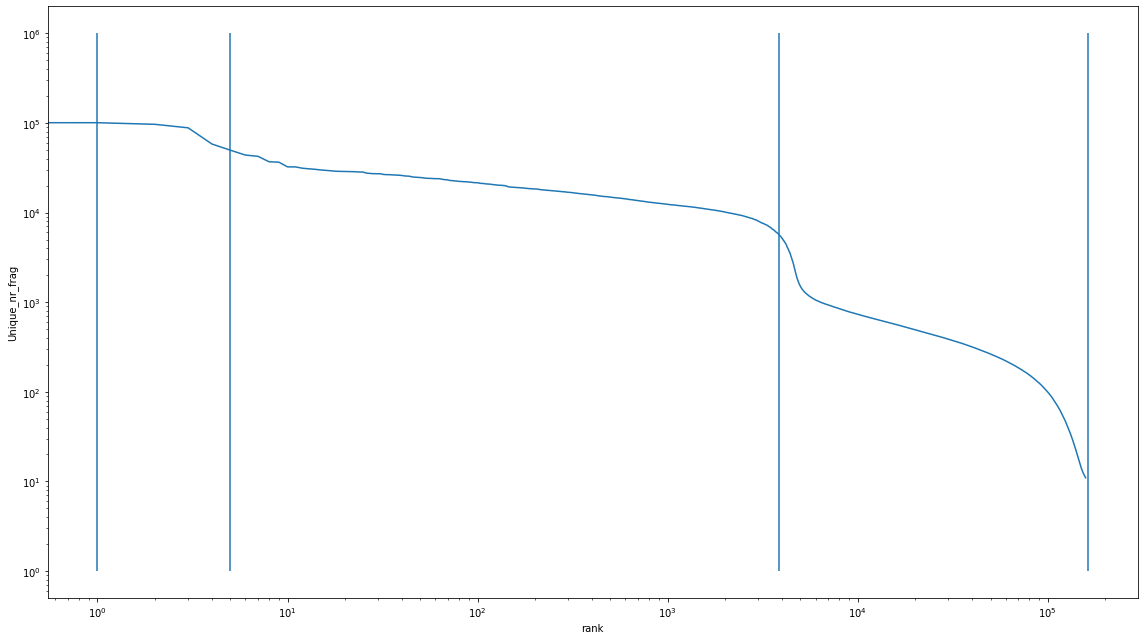

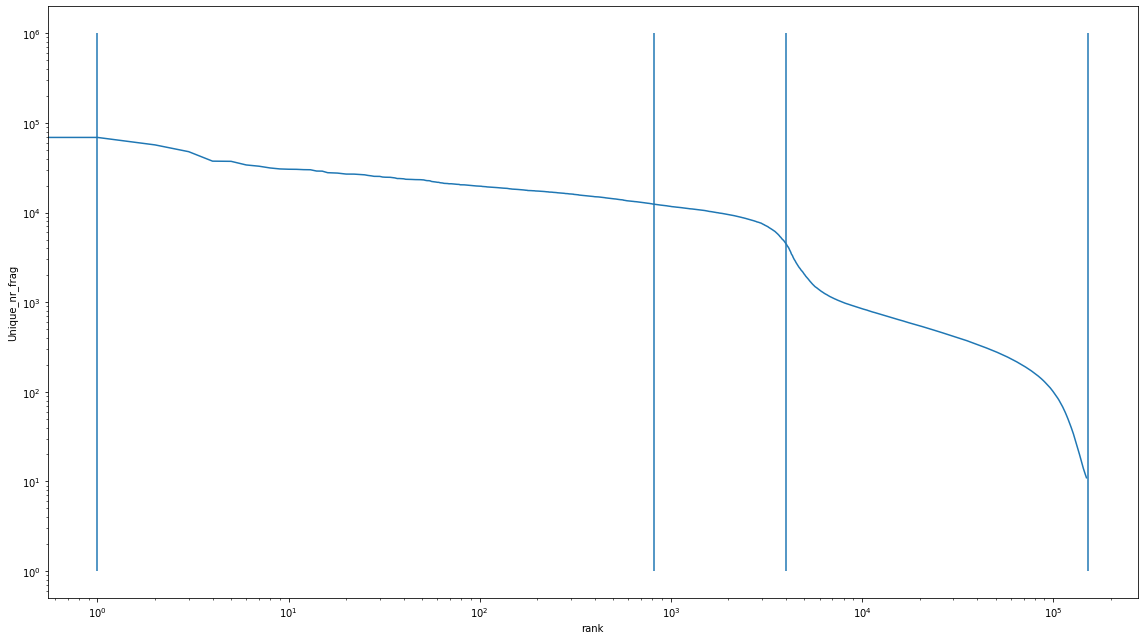

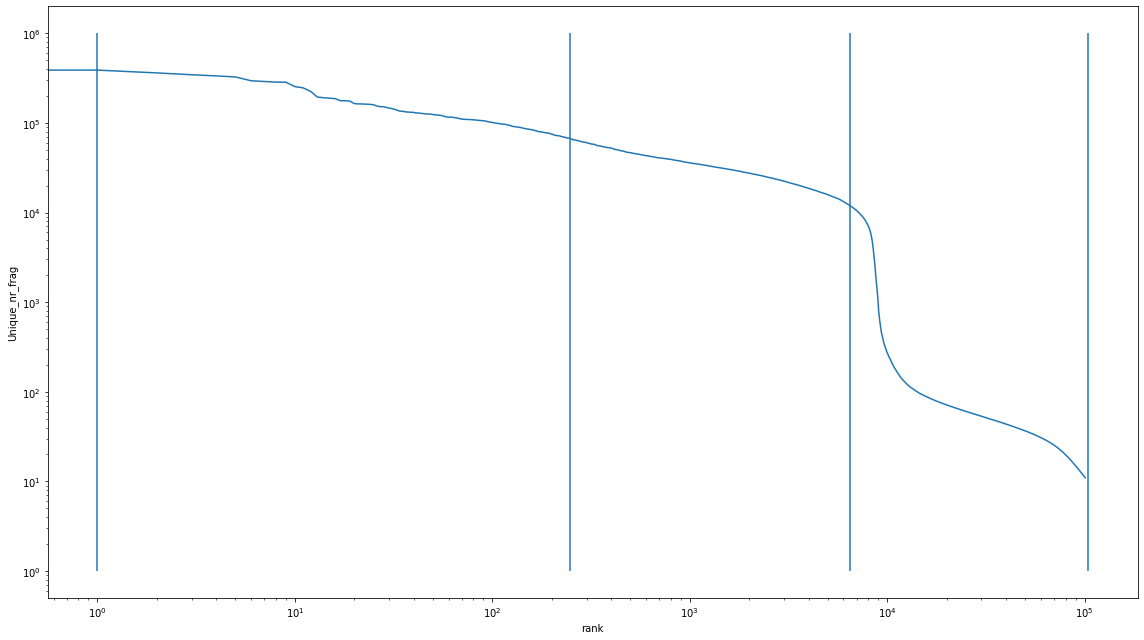

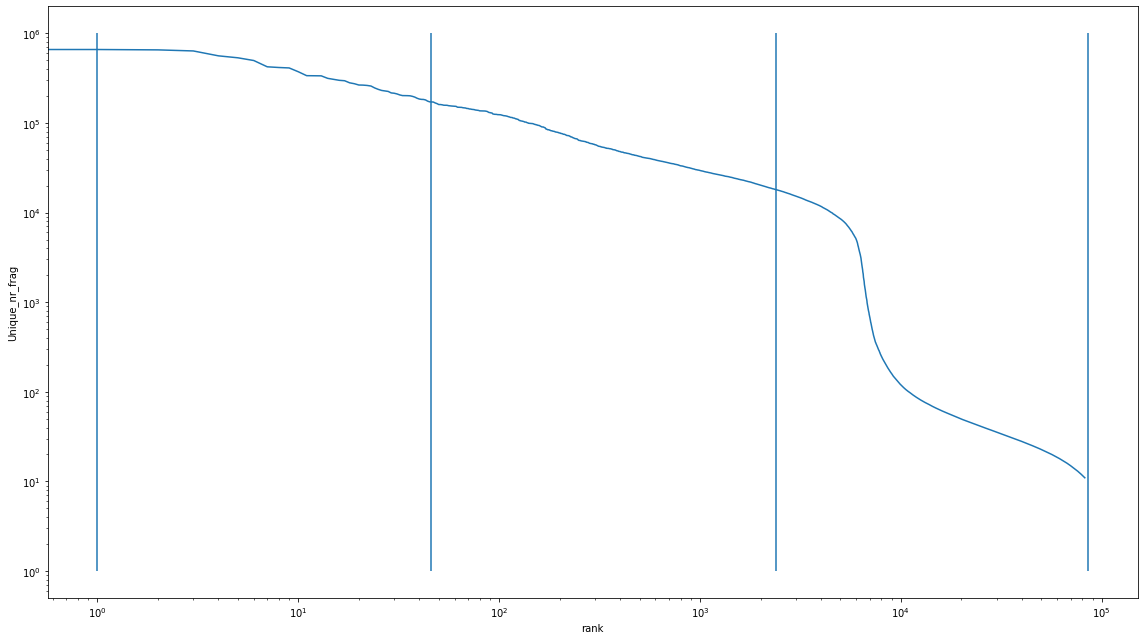

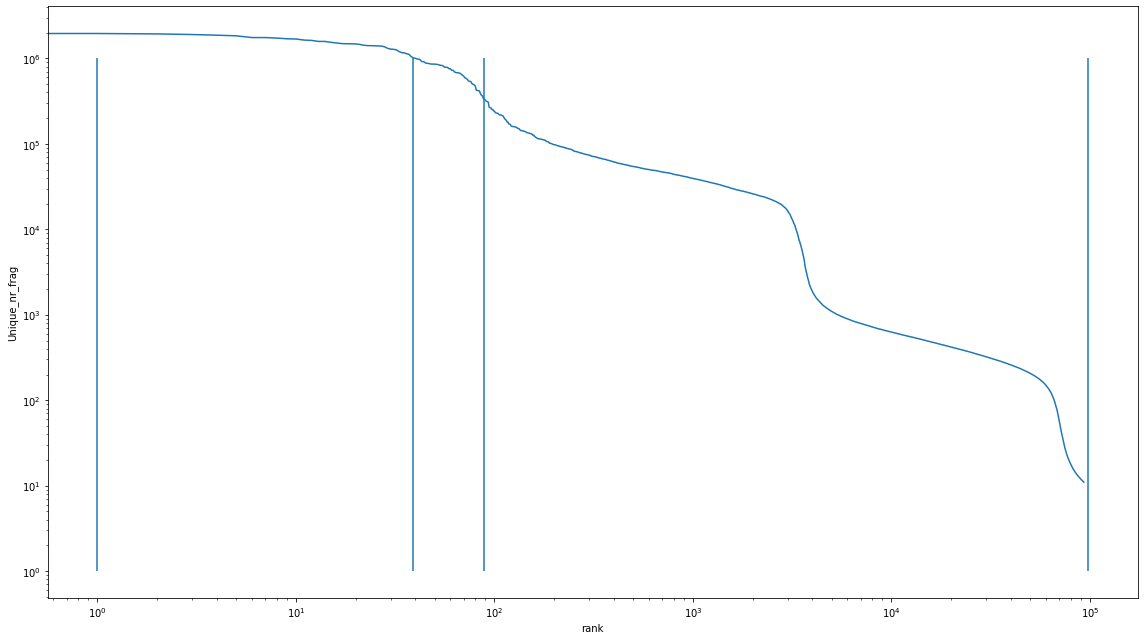

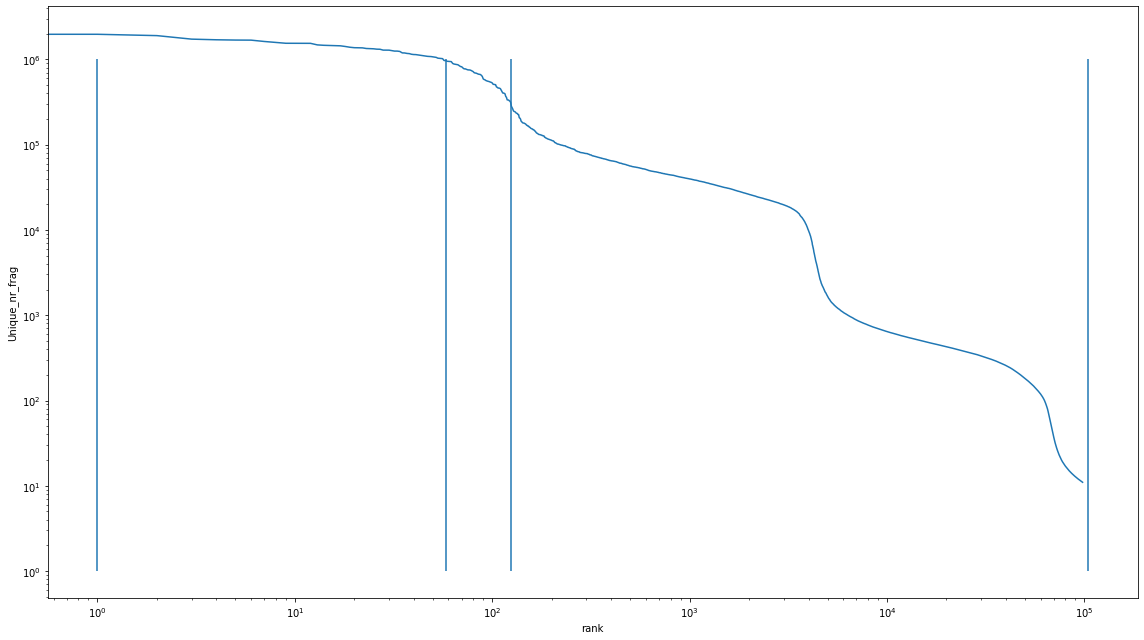

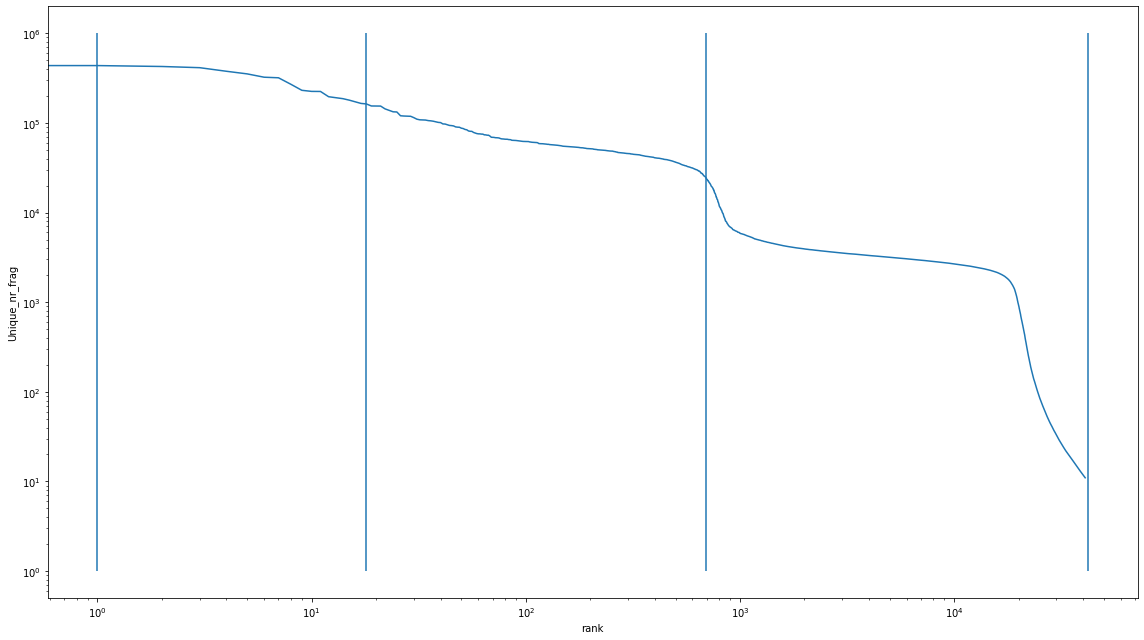

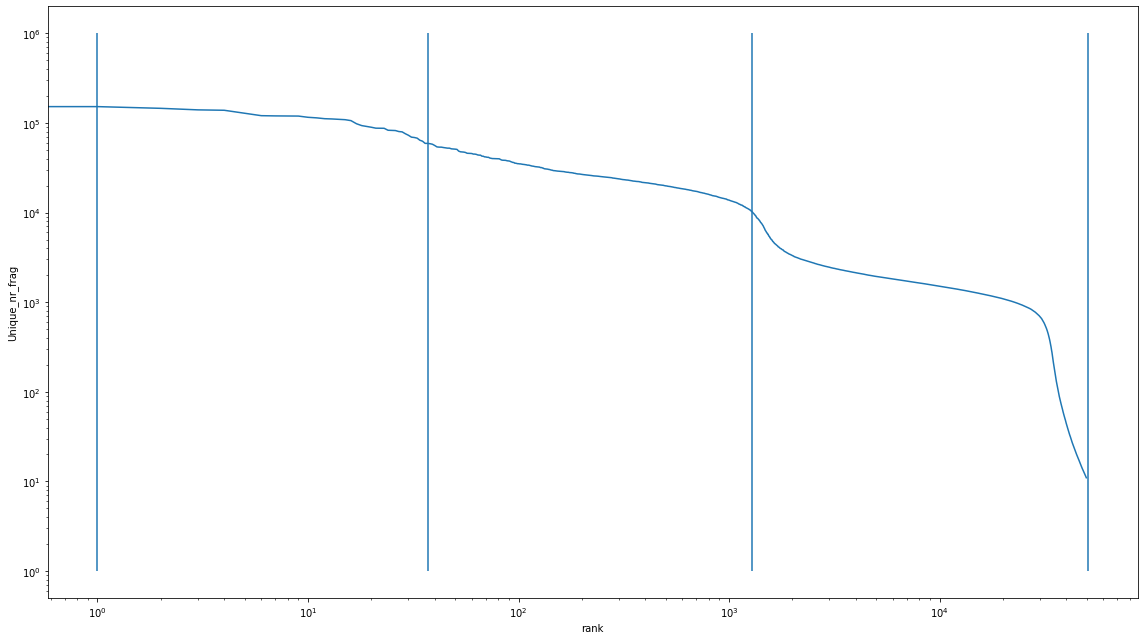

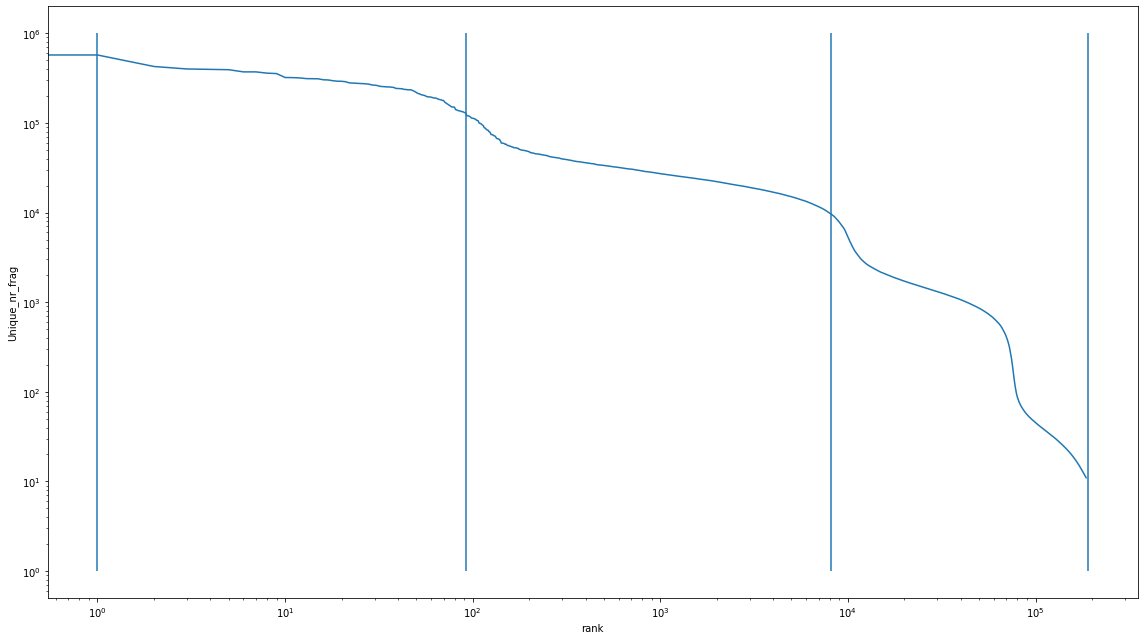

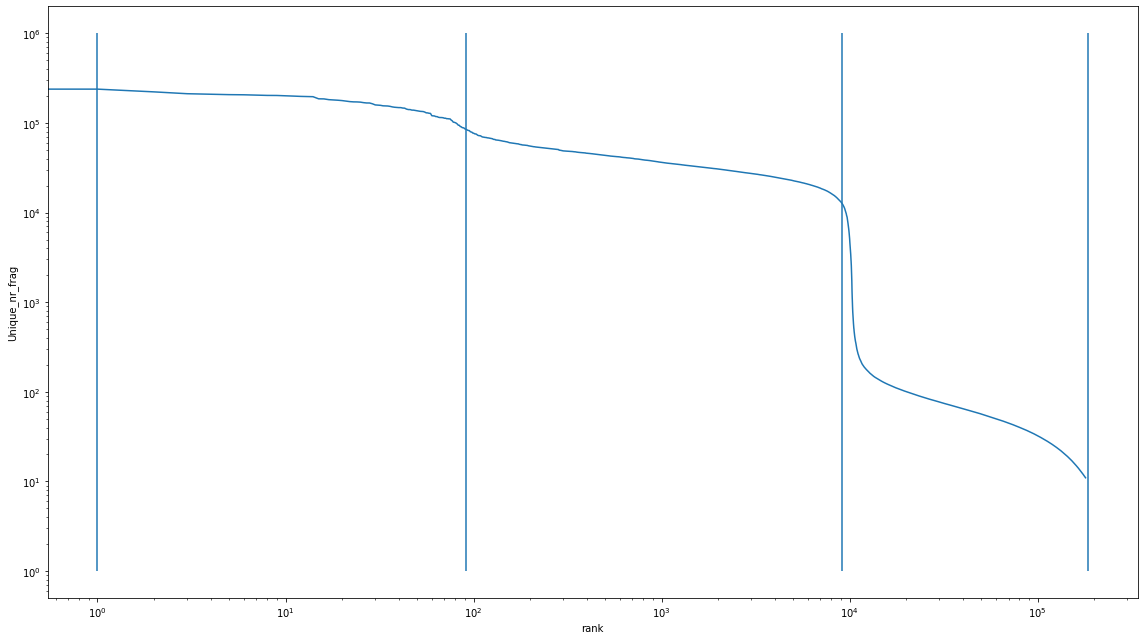

In [29]:
variable = "Unique_nr_frag"
for sample in sorted(metadata_bc_pkl_path_dict.keys()):
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    df = pd.DataFrame(metadata_bc_df[variable])
    # calculate otsu threshold
    df = df.sort_values(variable, ascending=False)


    df["rank"] = range(0, len(df))
    # df["log"] = np.log10(df[v])

    jn_breaks = jn.jenks_breaks(df[variable], nb_class=3)
    # thresholds = 10**jn_breaks

    # ncells = len(df[df["Unique_nr_frag"] > threshold])
    df_fast_knee = df.drop_duplicates(subset=[variable])

    # print(f"\tplotting {len(df_fast_knee)} values...")
    fig, ax = plt.subplots()
    sns.lineplot(data=df_fast_knee, x="rank", y=variable, ax=ax)


    for jn_break in jn_breaks:
        threshold = jn_break
        # plt.hlines(y=threshold, xmin=1, xmax=1000000)
        rank = len(df[df[variable] >= threshold])
        plt.vlines(x=rank, ymin=1, ymax=1000000)

    plt.xscale("log")
    plt.yscale("log")
    fig.set_size_inches(16, 9)

    # plt.title(f"{ncells} cells, minimum of {threshold} reads/barcode")
    plt.tight_layout()
    # plt.savefig(f"plts_bc_count/{run}.raw_kneeplot.png", facecolor="white", dpi=300)
    plt.show()
    plt.close()

# And what if we log-transform?

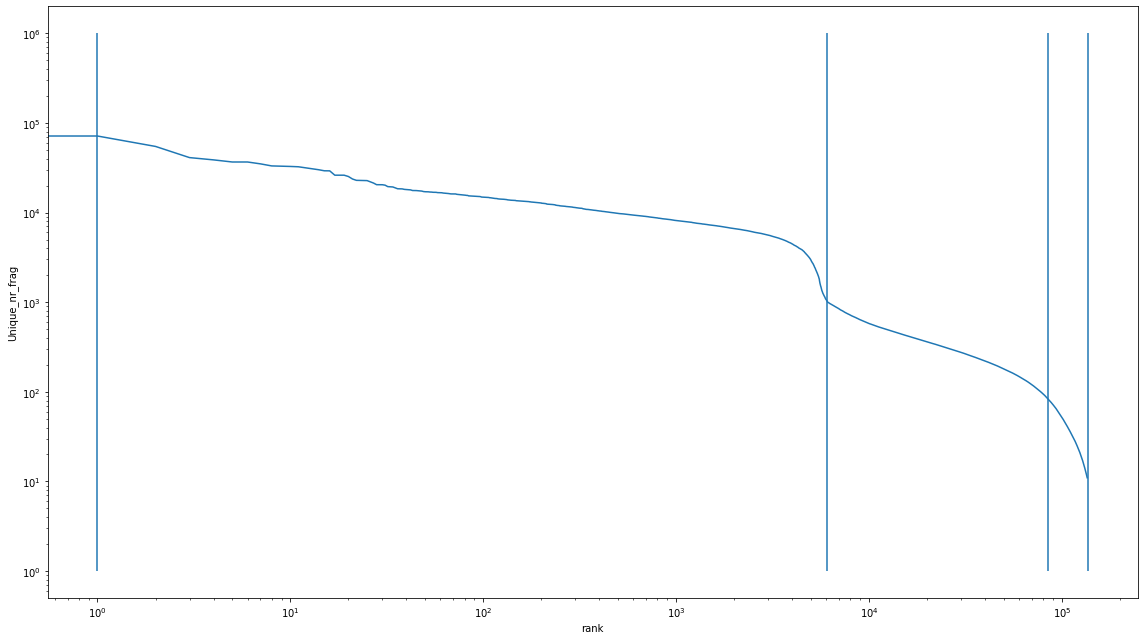

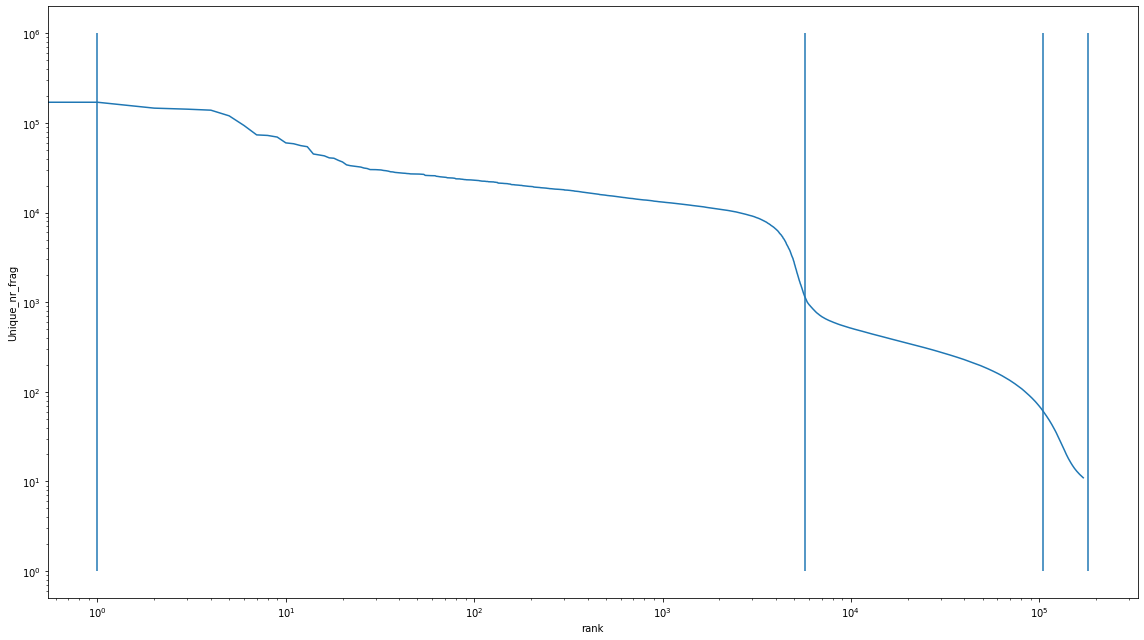

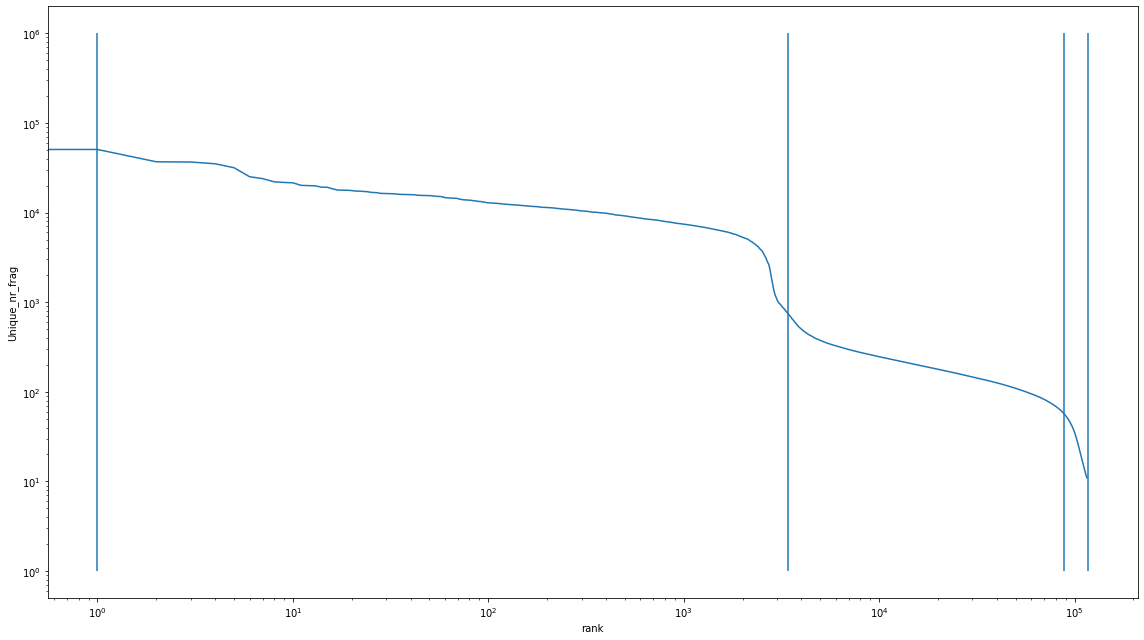

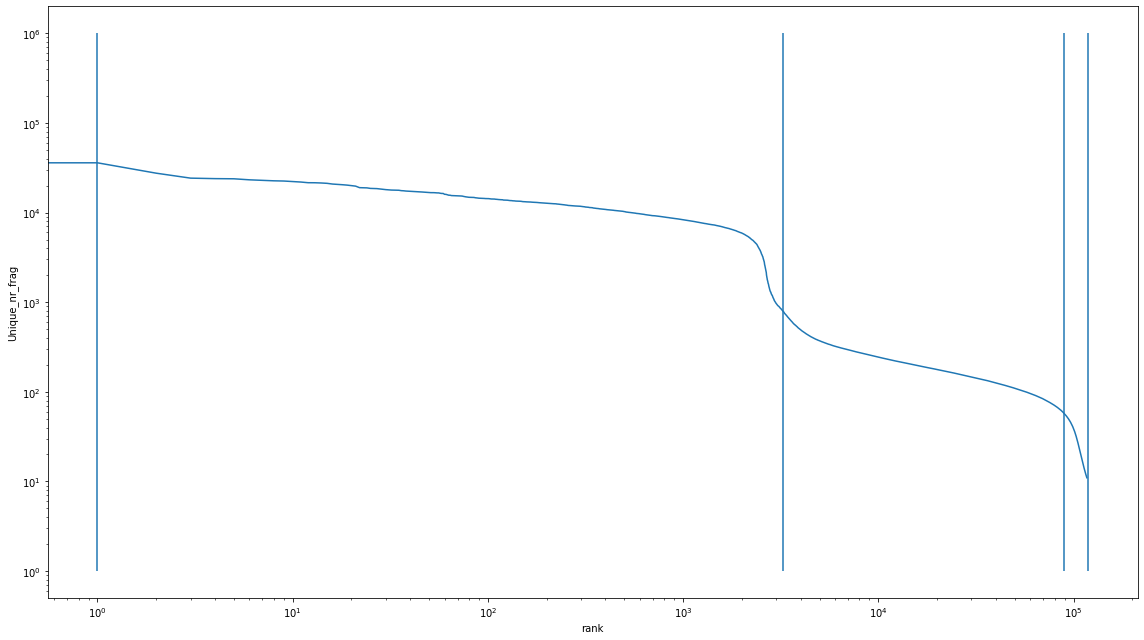

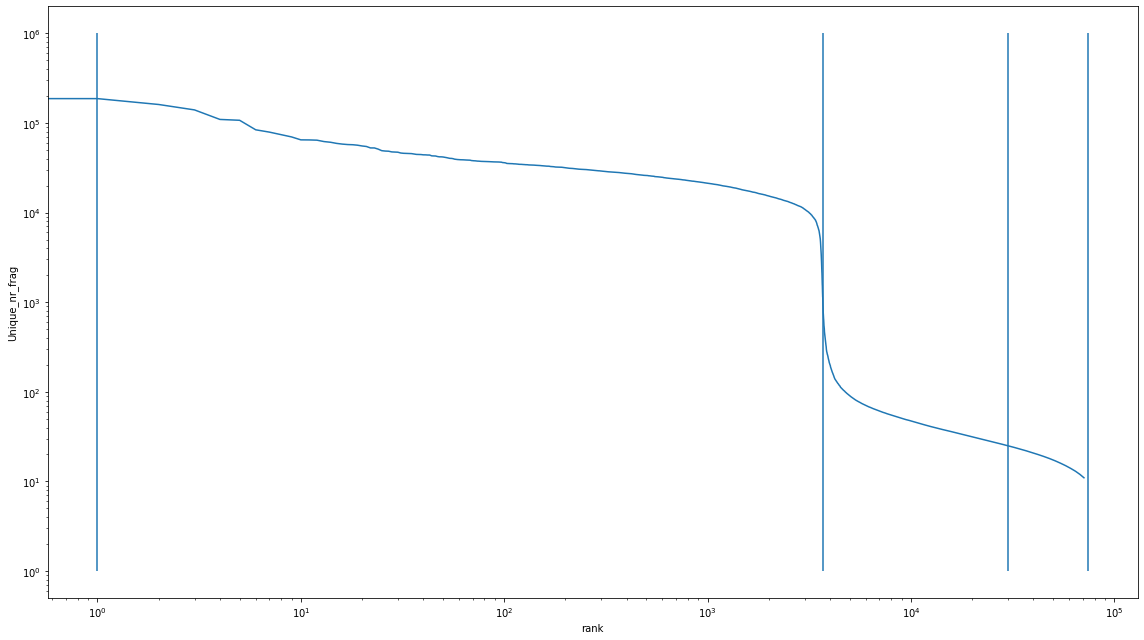

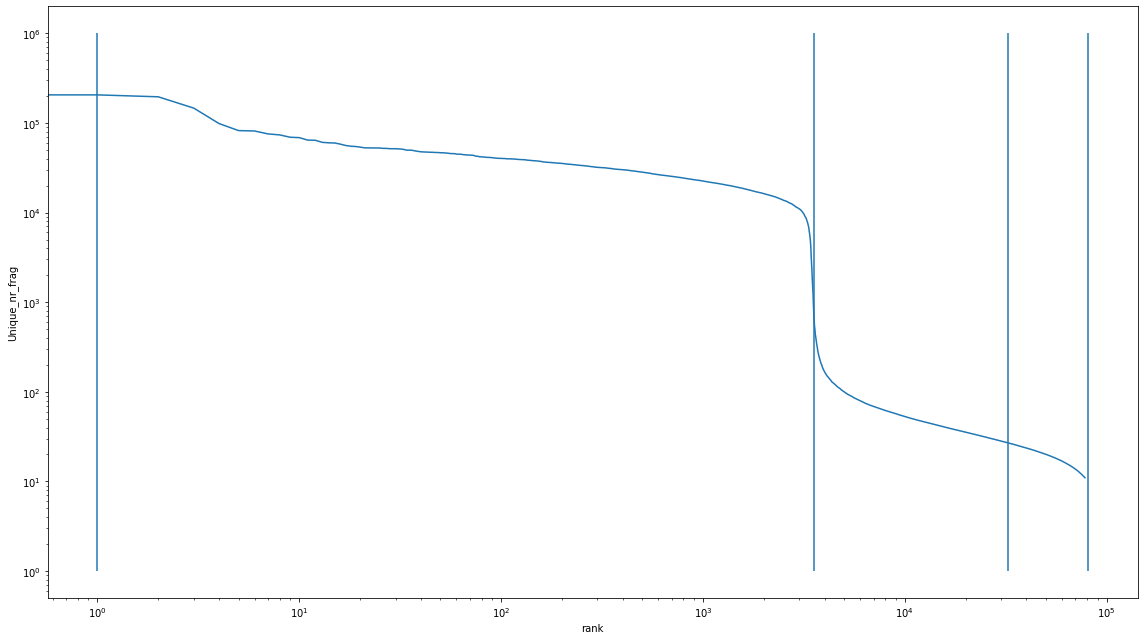

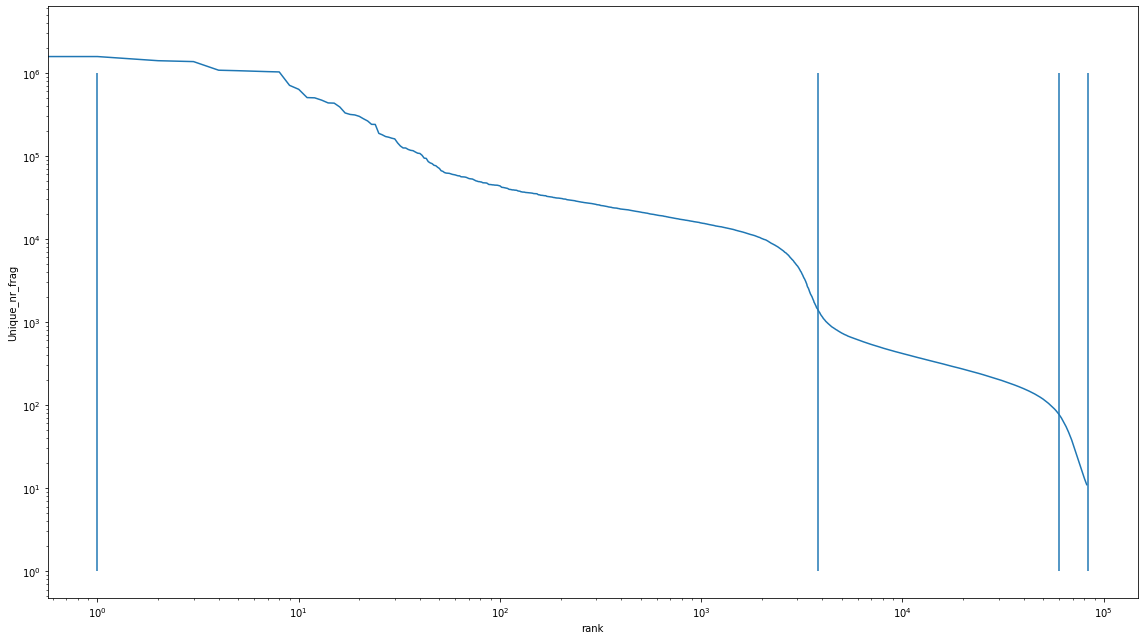

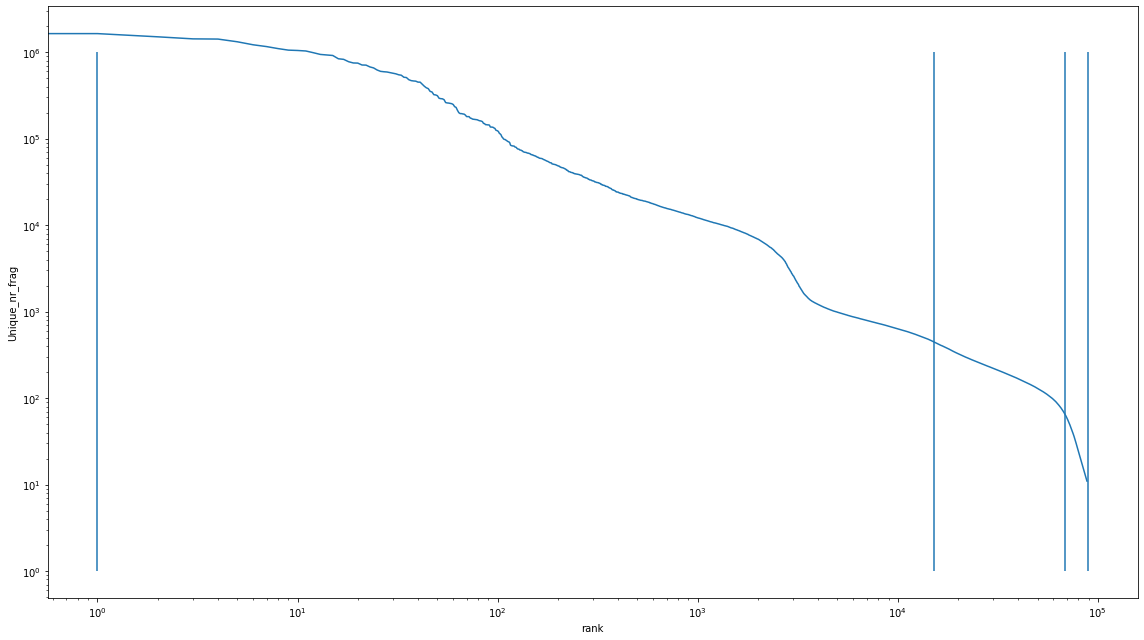

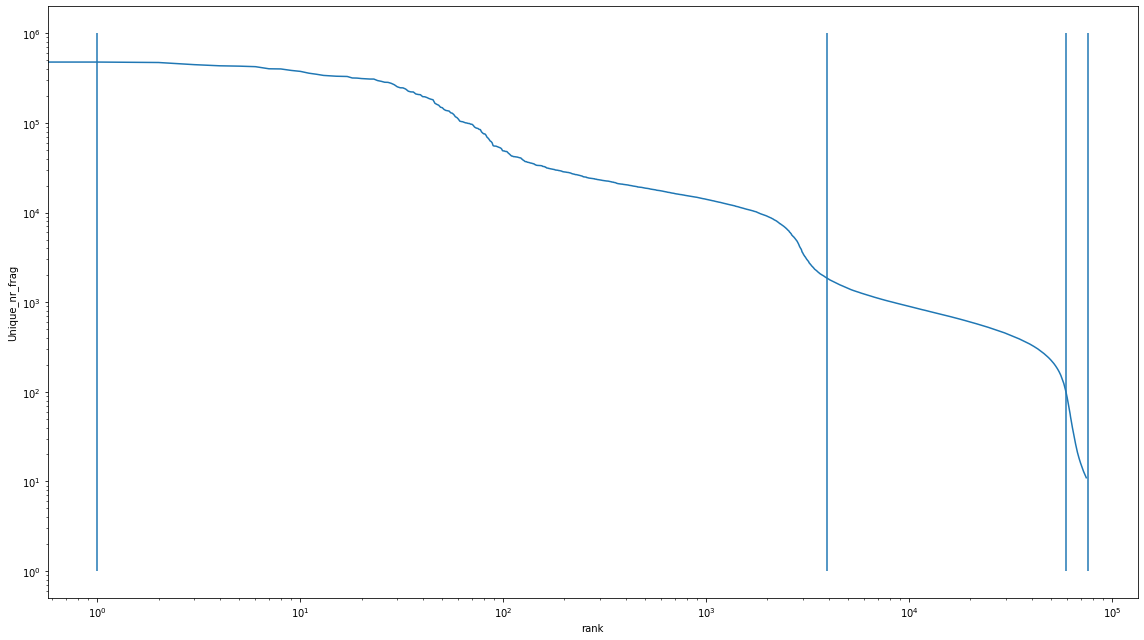

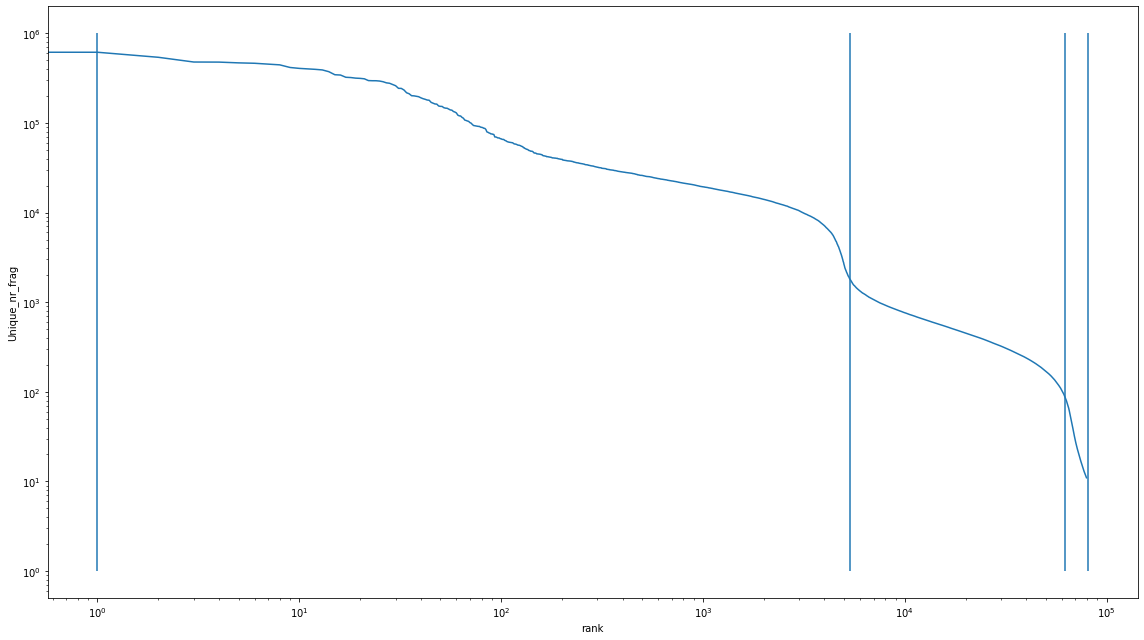

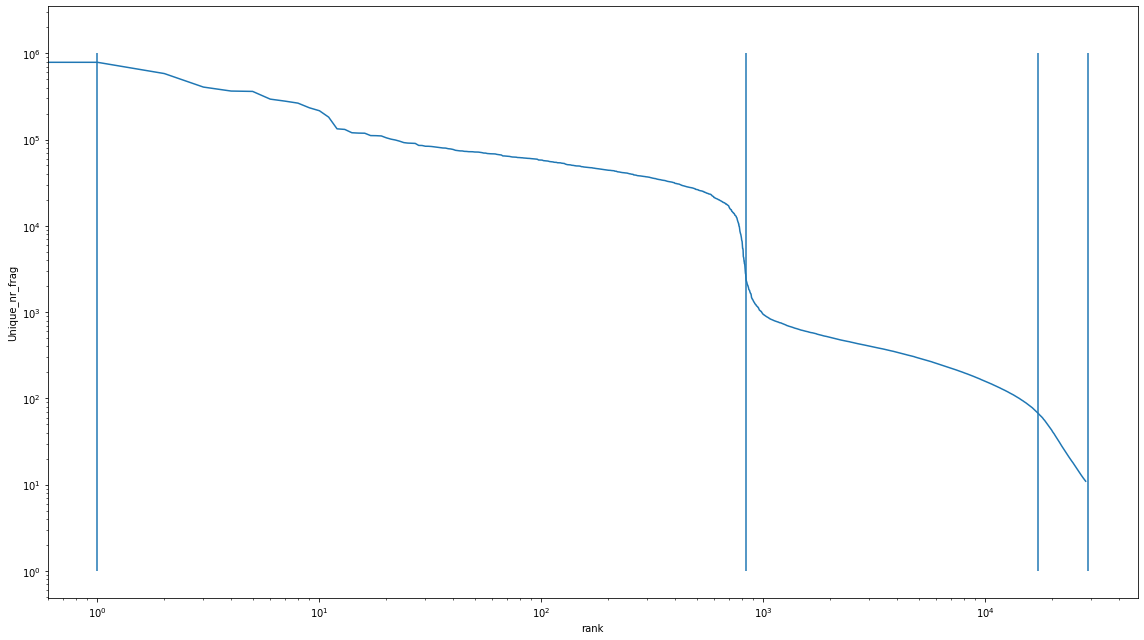

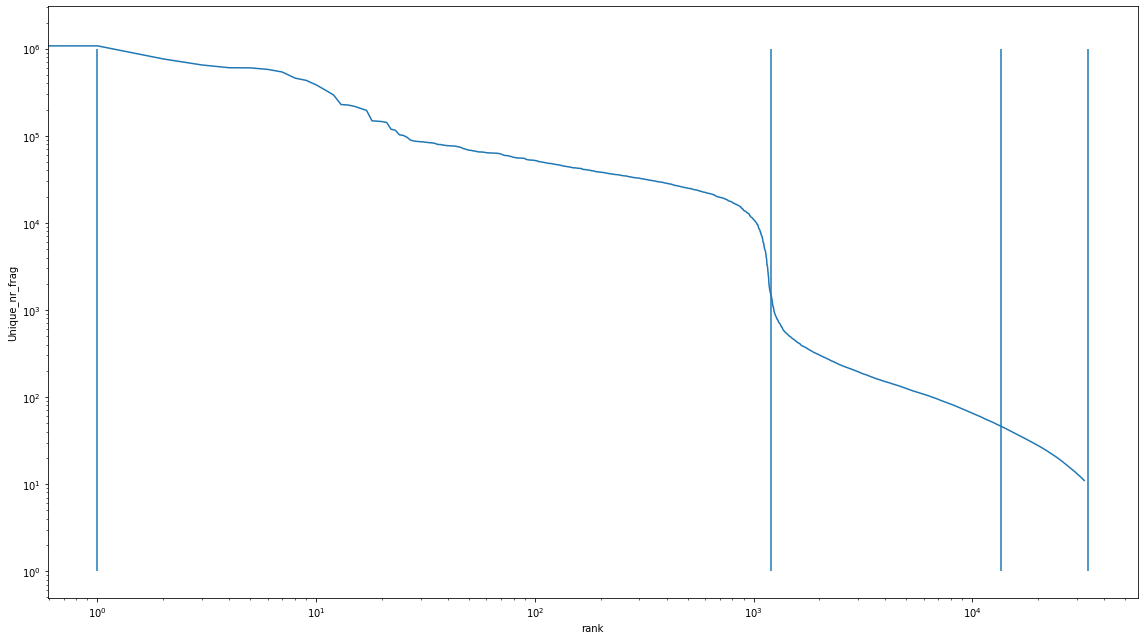

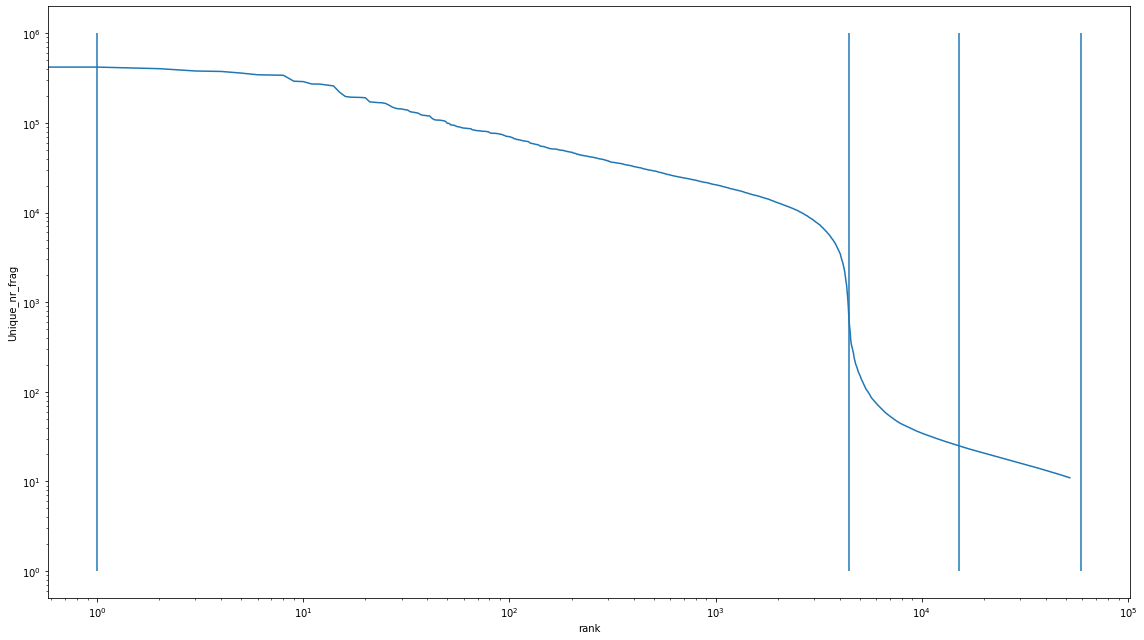

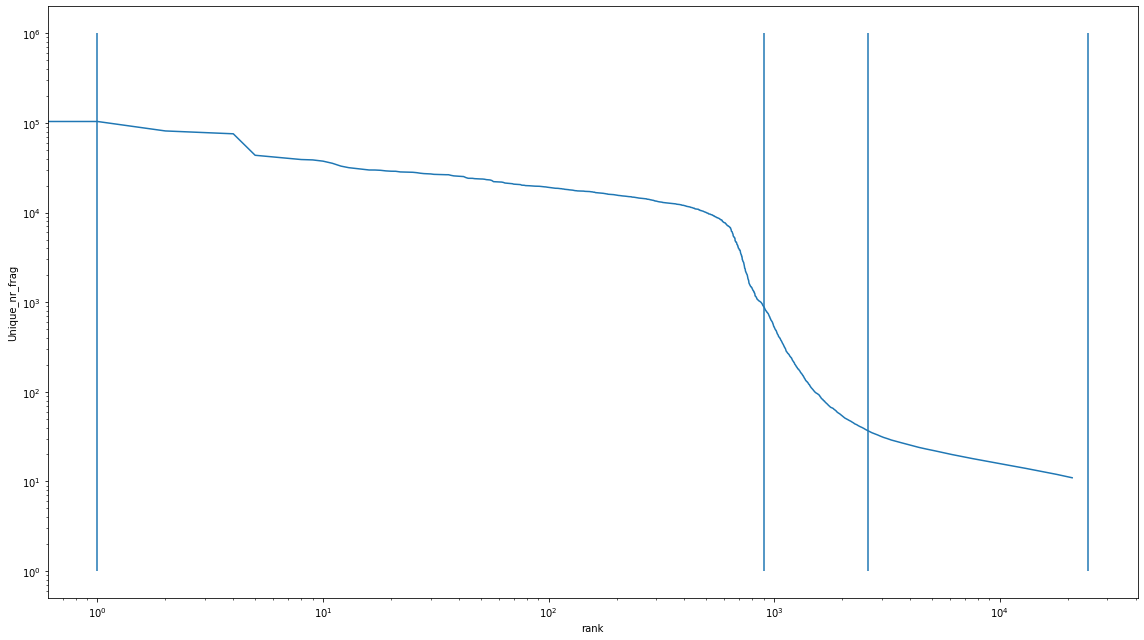

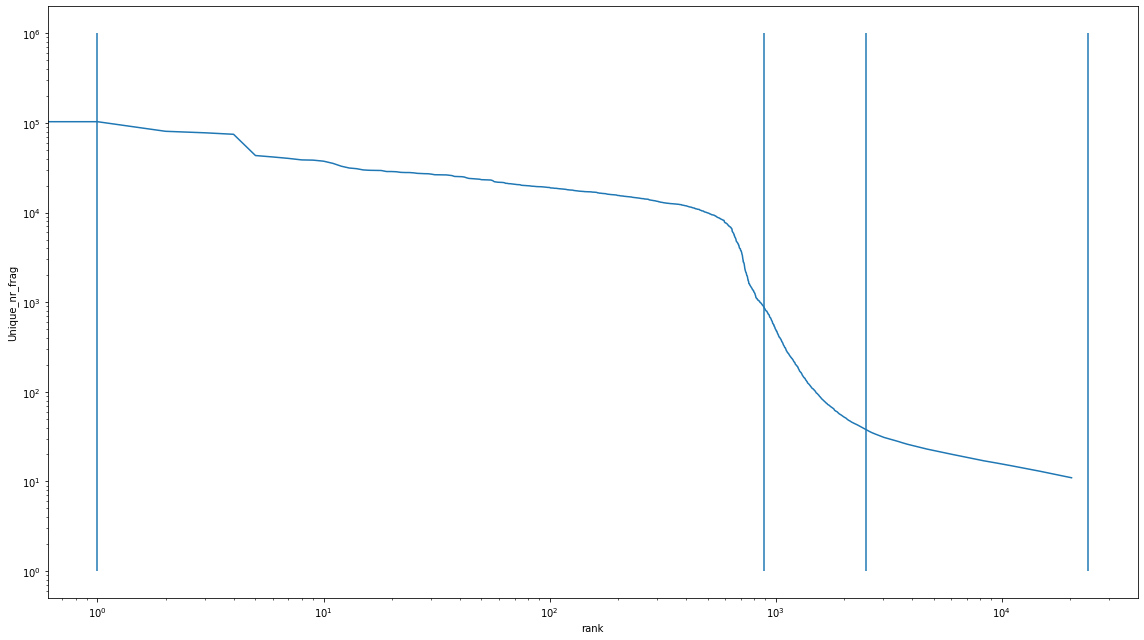

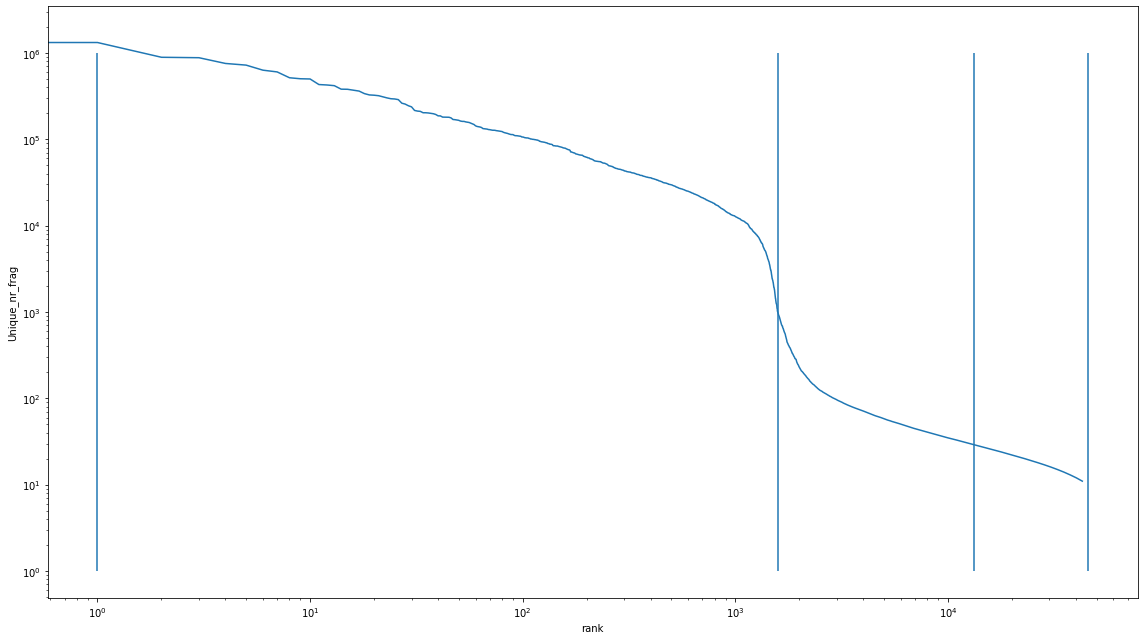

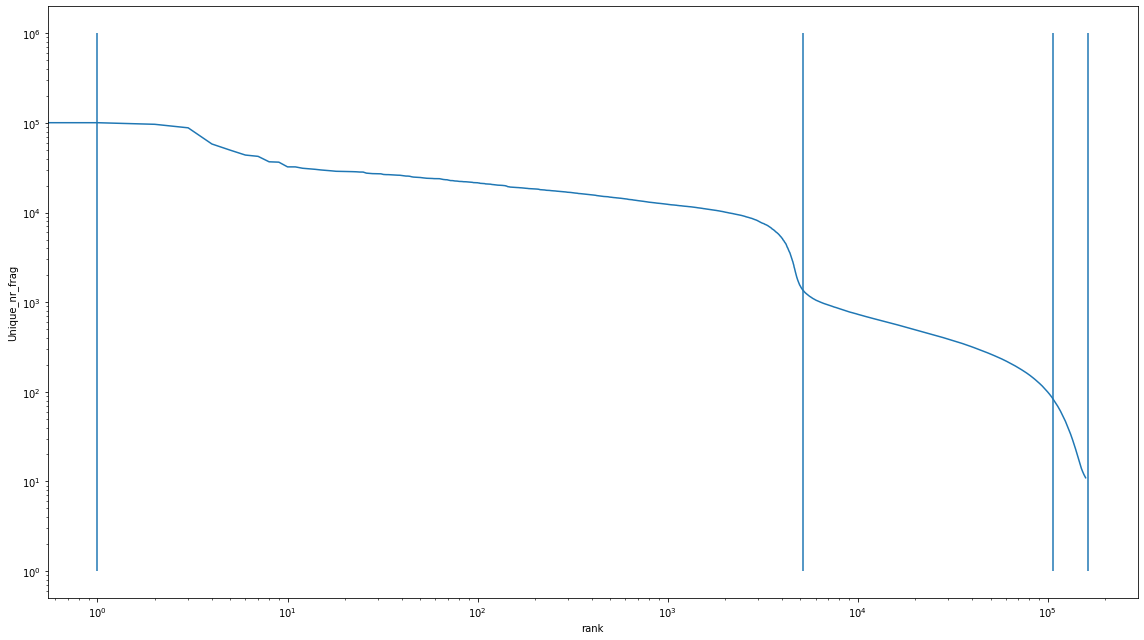

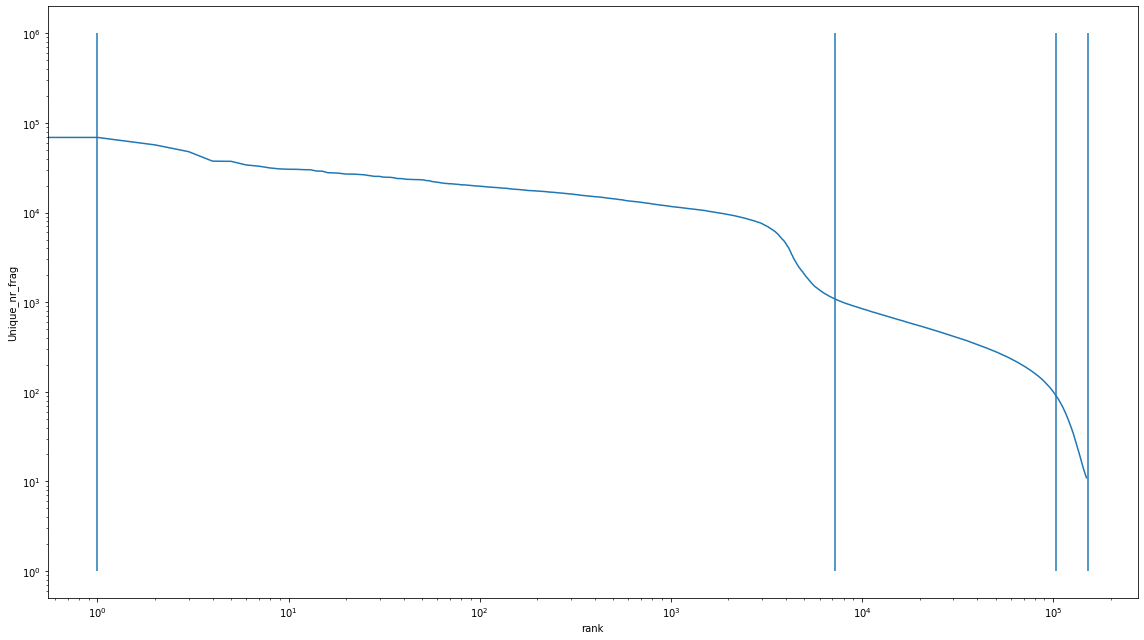

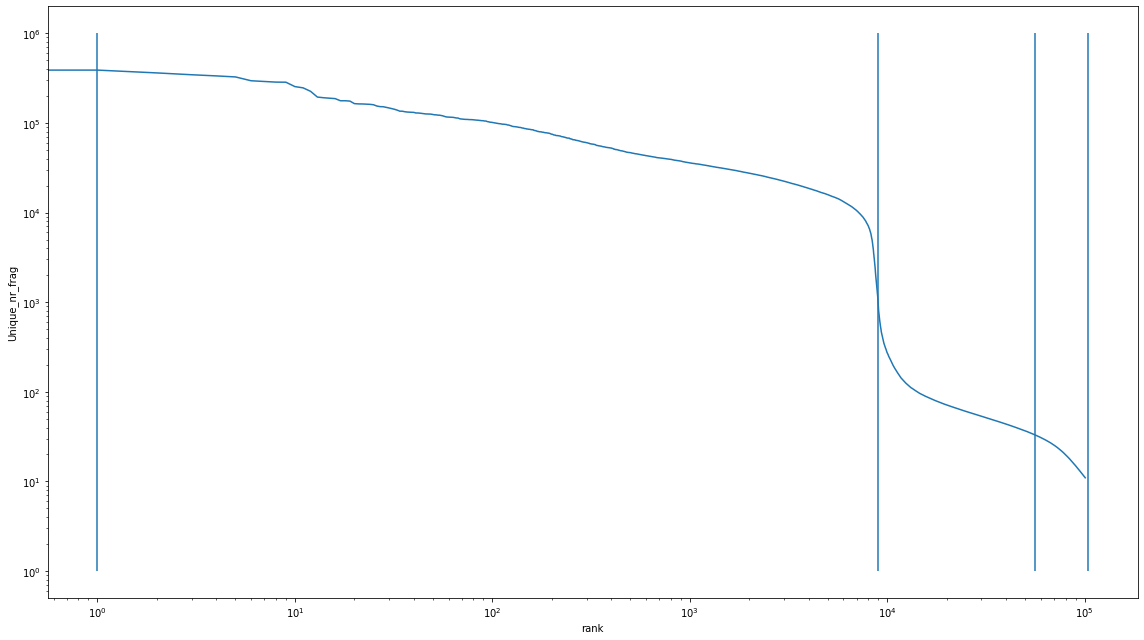

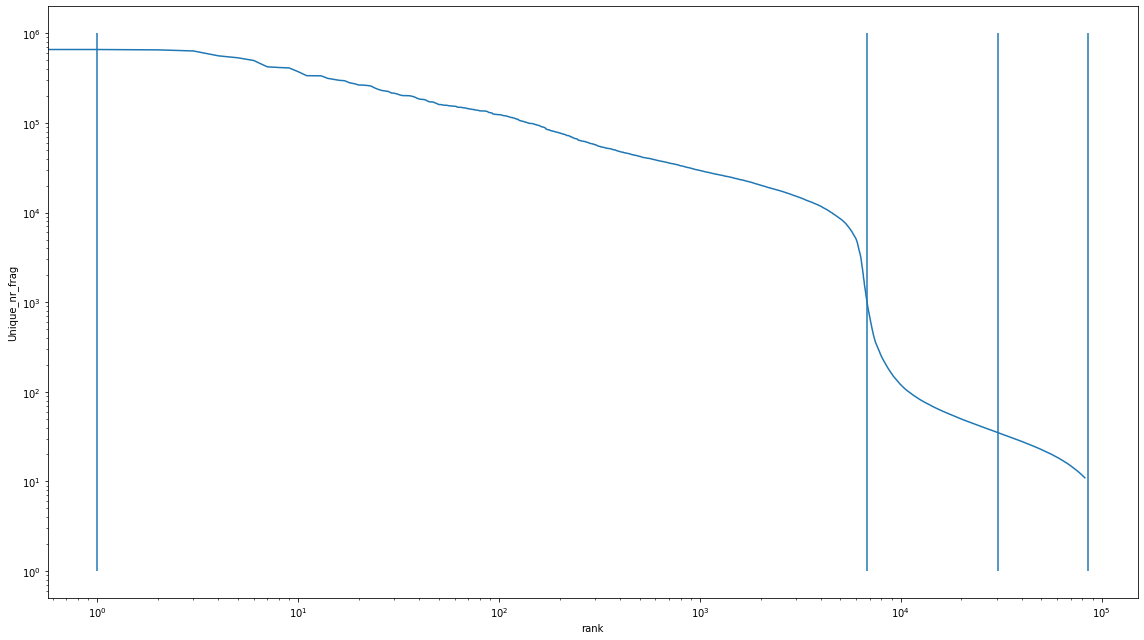

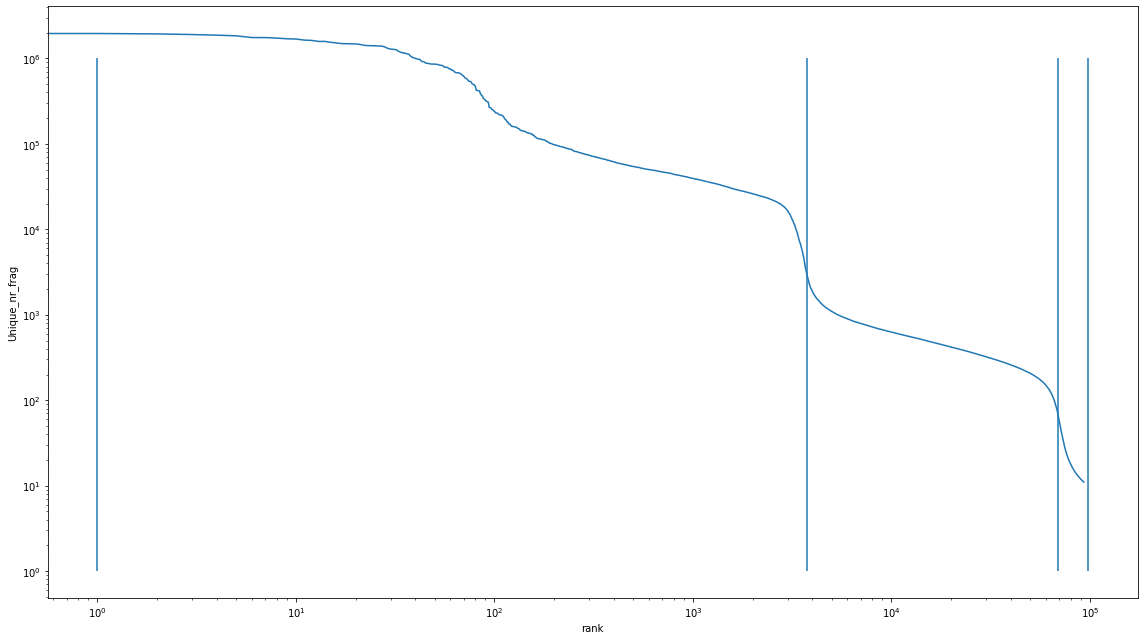

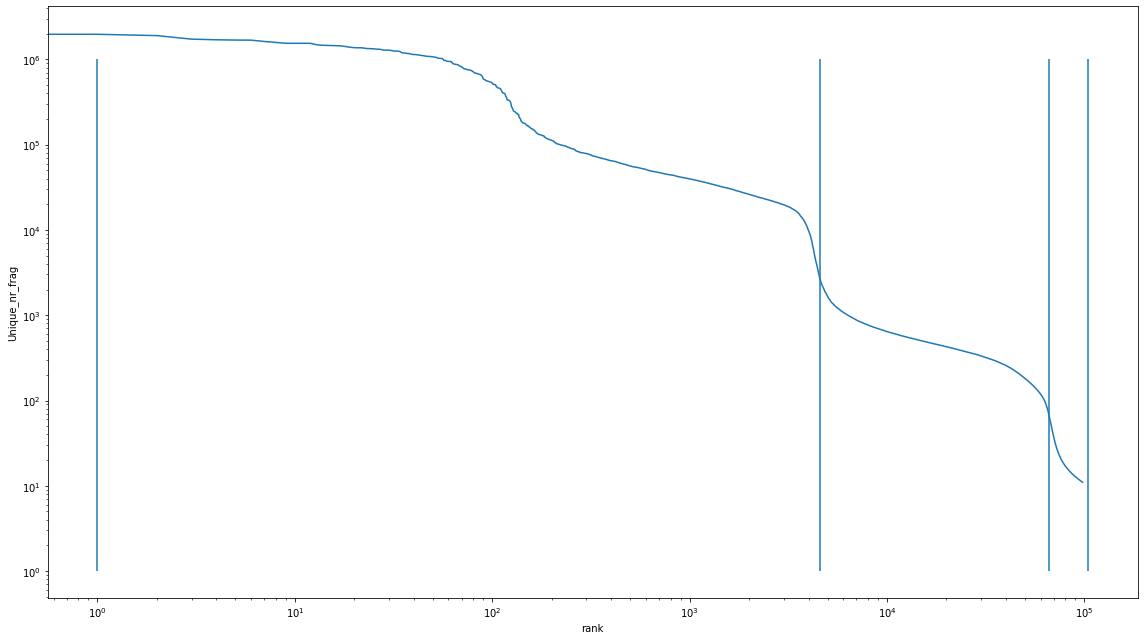

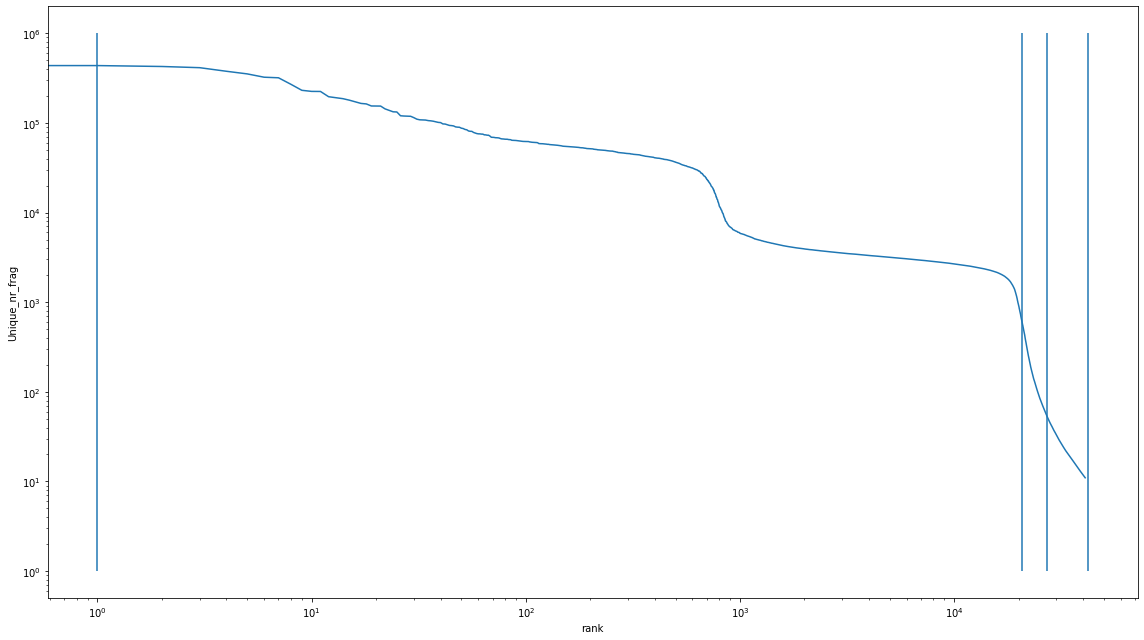

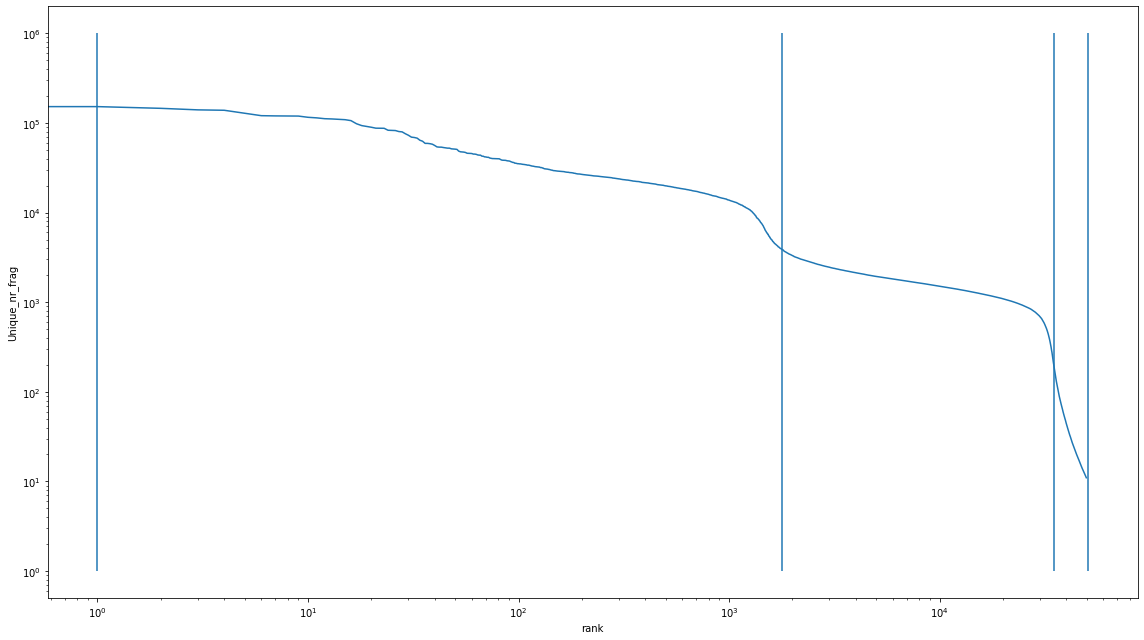

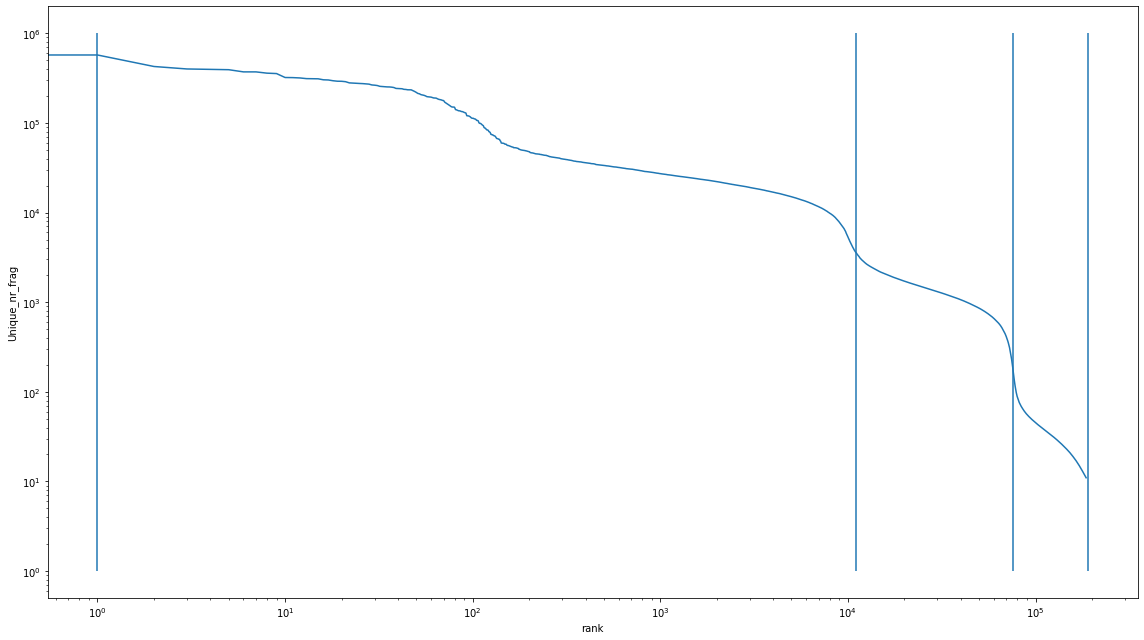

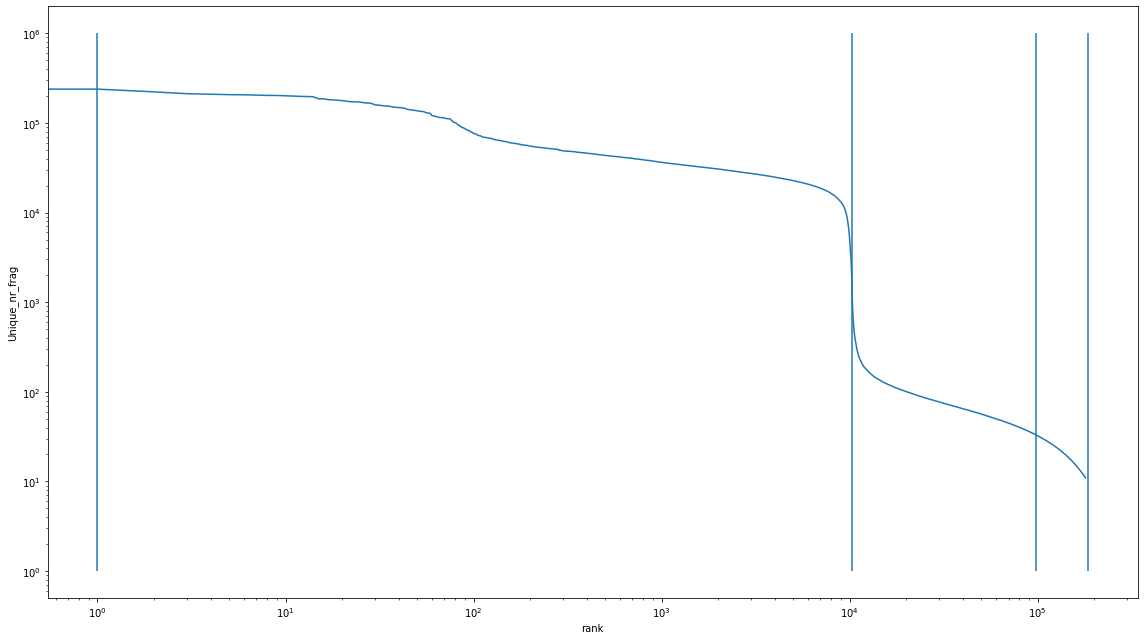

In [30]:
variable = "Log_unique_nr_frag"
for sample in sorted(metadata_bc_pkl_path_dict.keys()):
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    df = pd.DataFrame(metadata_bc_df)
    # calculate otsu threshold
    df = df.sort_values(variable, ascending=False)


    df["rank"] = range(0, len(df))
    # df["log"] = np.log10(df[v])

    jn_breaks = jn.jenks_breaks(df[variable], nb_class=3)
    # thresholds = 10**jn_breaks

    # ncells = len(df[df["Unique_nr_frag"] > threshold])
    df_fast_knee = df.drop_duplicates(subset=[variable])

    # print(f"\tplotting {len(df_fast_knee)} values...")
    fig, ax = plt.subplots()
    sns.lineplot(data=df_fast_knee, x="rank", y="Unique_nr_frag", ax=ax)


    for jn_break in jn_breaks:
        threshold = jn_break
        # plt.hlines(y=threshold, xmin=1, xmax=1000000)
        rank = len(df[df[variable] >= threshold])
        plt.vlines(x=rank, ymin=1, ymax=1000000)

    plt.xscale("log")
    plt.yscale("log")
    fig.set_size_inches(16, 9)

    # plt.title(f"{ncells} cells, minimum of {threshold} reads/barcode")
    plt.tight_layout()
    # plt.savefig(f"plts_bc_count/{run}.raw_kneeplot.png", facecolor="white", dpi=300)
    plt.show()
    plt.close()

What if we use GMM?

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
variable = "Log_unique_nr_frag"
for sample in sorted(metadata_bc_pkl_path_dict.keys()):
    
sample = "HAR_ddseq_1"
with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
    metadata_bc_df = pickle.load(fh)

df = pd.DataFrame(metadata_bc_df)
# calculate otsu threshold
df = df.sort_values(variable, ascending=False)


df["rank"] = range(0, len(df))
# df["log"] = np.log10(df[v])

jn_breaks = jn.jenks_breaks(df[variable], nb_class=3)
# thresholds = 10**jn_breaks

# ncells = len(df[df["Unique_nr_frag"] > threshold])
df_fast_knee = df.drop_duplicates(subset=[variable])

# print(f"\tplotting {len(df_fast_knee)} values...")
fig, ax = plt.subplots()
sns.lineplot(data=df_fast_knee, x="rank", y="Unique_nr_frag", ax=ax)


for jn_break in jn_breaks:
    threshold = jn_break
    # plt.hlines(y=threshold, xmin=1, xmax=1000000)
    rank = len(df[df[variable] >= threshold])
    plt.vlines(x=rank, ymin=1, ymax=1000000)

plt.xscale("log")
plt.yscale("log")
fig.set_size_inches(16, 9)

# plt.title(f"{ncells} cells, minimum of {threshold} reads/barcode")
plt.tight_layout()
# plt.savefig(f"plts_bc_count/{run}.raw_kneeplot.png", facecolor="white", dpi=300)
plt.show()
plt.close()